KineticAI - wind farm ramp detection using PINN modelling for all five turbines

Complete implementation with novel physics constraints:
1. Wake propagation dynamics between turbines
2. Terrain-induced turbulence modeling  
3. Dynamic power curve adaptation


Wind Farm A - 0, 10, 11, 13, 21
with coordinate of

wind turbine asset id = 0, coordinate 39.293112, -9.021902
asset id = 10, coordinate 39.292821, -9.025064
asset id = 11, coordinate 39.292642, -9.027933
asset id = 13, coordinate 39.290114, -9.030488
asset id = 21, coordinate 39.288331, -9.032520

the coordinate i checked using google map

with terrain 240m

From the coordinates, the turbines are arranged in a rough line from Northeast to Southwest. The spacing appears to be:

Turbine 0 → 10: ~250-300m (3-4 rotor diameters)

Turbine 10 → 11: ~200-250m (2.5-3 rotor diameters)

Turbine 11 → 13: ~300-350m (4-4.5 rotor diameters)

Turbine 13 → 21: ~250-300m (3-4 rotor diameters)


Lets go step-by-step

To make everything clearer

First we need to combine the datasets

Phase 1 Data cleaning, preprocessing

In [2]:
pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 404.7/404.7 kB 13.6 MB/s eta 0:00:00


Phase 1 Import libraries and setup

In [3]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (mean_squared_error, mean_absolute_error,
                           r2_score, f1_score, confusion_matrix)
import xgboost as xgb
import optuna
import logging
import warnings
from typing import Dict, List, Tuple, Any, Optional
import time
import sys
from datetime import datetime
import os
from math import radians, sin, cos, sqrt, atan2

warnings.filterwarnings('ignore')

# Set seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Setup logging
logging.basicConfig(level=logging.INFO, format='%(message)s')
logger = logging.getLogger()

Phase 1 Load all turbine datasets

In [4]:
def load_turbine_data():
    """Load all turbine datasets"""
    print("📂 Loading all 5 turbine datasets...")

    turbine_files = {
        'windturbine0': '/content/drive/MyDrive/data scada/CARE_to_Compare/Wind Farm A/datasets/windturbine0.csv',
        'windturbine10': '/content/drive/MyDrive/data scada/CARE_to_Compare/Wind Farm A/datasets/windturbine10.csv',
        'windturbine11': '/content/drive/MyDrive/data scada/CARE_to_Compare/Wind Farm A/datasets/windturbine11.csv',
        'windturbine13': '/content/drive/MyDrive/data scada/CARE_to_Compare/Wind Farm A/datasets/windturbine13.csv',
        'windturbine21': '/content/drive/MyDrive/data scada/CARE_to_Compare/Wind Farm A/datasets/windturbine21.csv'
    }

    turbine_data = {}
    for name, file_path in turbine_files.items():
        try:
            df = pd.read_csv(file_path)
            df['time_stamp'] = pd.to_datetime(df['time_stamp'])
            turbine_data[name] = df

            n_rows, n_cols = df.shape
            print(f"✅ {name}: {n_rows} records | {n_cols} columns | "
                  f"{df['time_stamp'].min()} → {df['time_stamp'].max()}")
        except Exception as e:
            print(f"❌ Failed to load {name}: {e}")

    print(f"\n🎯 Successfully loaded {len(turbine_data)} turbines")
    return turbine_data

def prepare_data_with_seasons(df, target_col='power_30_avg'):
    """Prepare data with seasonal information for comprehensive analysis - FIXED VERSION"""
    # Filter normal operation status
    normal_status = [0, 2]
    df_clean = df[df['status_type_id'].isin(normal_status)].copy()

    # Define all possible features
    FEATURES = [
        'sensor_0_avg', 'sensor_1_avg', 'sensor_2_avg', 'wind_speed_3_avg',
        'sensor_5_avg', 'sensor_6_avg', 'sensor_7_avg', 'sensor_8_avg',
        'sensor_9_avg', 'sensor_10_avg', 'sensor_11_avg', 'sensor_12_avg',
        'sensor_13_avg', 'sensor_14_avg', 'sensor_15_avg', 'sensor_16_avg',
        'sensor_17_avg', 'sensor_18_avg', 'sensor_19_avg', 'sensor_20_avg',
        'sensor_21_avg', 'sensor_26_avg', 'sensor_35_avg', 'sensor_36_avg',
        'sensor_37_avg', 'sensor_38_avg', 'sensor_39_avg', 'sensor_40_avg',
        'sensor_41_avg', 'sensor_42_avg', 'sensor_43_avg', 'sensor_52_avg',
        'sensor_53_avg'
    ]

    # Get available features
    available_features = [f for f in FEATURES if f in df_clean.columns]
    model_data = df_clean[available_features + [target_col]].dropna()

    X = model_data[available_features].values
    y = model_data[target_col].values

    # Add seasonal information if timestamps available
    if 'time_stamp' in df.columns:
        timestamps = pd.to_datetime(df['time_stamp']).iloc[model_data.index]
        months = timestamps.dt.month.values
        # Map months to seasons
        seasons = []
        for month in months:
            if month in [12, 1, 2]:
                seasons.append('winter')
            elif month in [3, 4, 5]:
                seasons.append('spring')
            elif month in [6, 7, 8]:
                seasons.append('summer')
            else:
                seasons.append('autumn')
    else:
        months = np.zeros(len(X))
        seasons = ['unknown'] * len(X)

    return X, y, months, seasons, available_features

In [5]:
print("Step 1: Loading turbine data...")
turbine_data = load_turbine_data()

Step 1: Loading turbine data...
📂 Loading all 5 turbine datasets...
✅ windturbine0: 52298 records | 36 columns | 2022-07-01 00:00:00 → 2023-06-30 23:50:00
✅ windturbine10: 52227 records | 36 columns | 2022-07-01 00:00:00 → 2023-06-30 23:50:00
✅ windturbine11: 52274 records | 36 columns | 2022-07-01 00:00:00 → 2023-06-30 23:50:00
✅ windturbine13: 52291 records | 36 columns | 2022-07-01 00:00:00 → 2023-06-30 23:50:00
✅ windturbine21: 50437 records | 36 columns | 2022-07-01 00:00:00 → 2023-06-30 23:50:00

🎯 Successfully loaded 5 turbines


PHASE 2: PINN MODEL DEVELOPMENT

Cell 5: Enhanced Multi-Physics PINN Model

Define and calculate physics constraints engineering

1. Wake effect
2. Terrain induced turbulence
3. Dynamic power curve

In [5]:
class AdvancedPhysicsEngine:
    """Physics engine with NOVEL constraints: wake, terrain, dynamic power curve"""

    def __init__(self, turbine_coordinates, hub_height=78, rotor_diameter=80,
                 rated_power=2000, terrain_elevation=240):
        self.turbine_coordinates = turbine_coordinates
        self.hub_height = hub_height
        self.rotor_diameter = rotor_diameter
        self.rotor_radius = rotor_diameter / 2
        self.rated_power = rated_power
        self.terrain_elevation = terrain_elevation
        self.air_density_sea_level = 1.225

        # Novel: Calculate spatial relationships for wake modeling
        self._calculate_spatial_relationships()

        # Novel: Terrain parameters
        self.roughness_length = 0.1  # Open terrain
        self.terrain_slope = 0.02    # 2% average slope

    def _calculate_spatial_relationships(self):
        """Calculate distances and bearings for wake propagation modeling"""
        self.turbine_ids = list(self.turbine_coordinates.keys())
        self.distance_matrix = {}
        self.bearing_matrix = {}

        for i, tid1 in enumerate(self.turbine_ids):
            for tid2 in self.turbine_ids[i+1:]:
                lat1, lon1 = self.turbine_coordinates[tid1]
                lat2, lon2 = self.turbine_coordinates[tid2]

                # Haversine distance
                R = 6371000
                dlat = radians(lat2 - lat1)
                dlon = radians(lon2 - lon1)
                a = sin(dlat/2)**2 + cos(radians(lat1)) * cos(radians(lat2)) * sin(dlon/2)**2
                c = 2 * atan2(sqrt(a), sqrt(1-a))
                distance = R * c

                # Bearing for wake direction
                y = sin(dlon) * cos(radians(lat2))
                x = cos(radians(lat1)) * sin(radians(lat2)) - sin(radians(lat1)) * cos(radians(lat2)) * cos(dlon)
                bearing = (atan2(y, x) * 180 / np.pi + 360) % 360

                self.distance_matrix[(tid1, tid2)] = distance
                self.distance_matrix[(tid2, tid1)] = distance
                self.bearing_matrix[(tid1, tid2)] = bearing
                self.bearing_matrix[(tid2, tid1)] = (bearing + 180) % 360

    # ==================== NOVEL PHYSICS 1: DYNAMIC POWER CURVE ====================
    def dynamic_power_curve(self, wind_speed, temperature, pressure=101325,
                           air_density_correction=True):
        """
        Dynamic power curve adapting to atmospheric conditions
        Novel: Adapts to air density changes from temperature/pressure
        """
        # Standard cut-in, rated, cut-out speeds
        cut_in = 4.0
        rated = 15.0
        cut_out = 25.0

        if wind_speed < cut_in or wind_speed > cut_out:
            return 0.0

        # Novel: Air density correction
        if air_density_correction:
            air_density = self.calculate_air_density(temperature, pressure)
            density_ratio = air_density / self.air_density_sea_level
        else:
            density_ratio = 1.0

        # Betz limit with practical efficiency
        cp_max = 0.45 * density_ratio ** (1/3)  # Scale with air density
        area = np.pi * (self.rotor_radius ** 2)

        if wind_speed < rated:
            # Cubic region with density correction
            power = 0.5 * self.air_density_sea_level * area * cp_max * (wind_speed ** 3)
            power = min(power, self.rated_power)
        else:
            # Rated region
            power = self.rated_power

        # Novel: Temperature derating (efficiency drops with temperature)
        temperature_kelvin = temperature + 273.15
        if temperature_kelvin > 298.15:  # Above 25°C
            temp_derating = 1.0 - 0.005 * (temperature_kelvin - 298.15)  # 0.5% per °C above 25°C
            power *= max(0.8, temp_derating)  # Minimum 80% efficiency

        return power / self.rated_power  # Normalized

    def calculate_air_density(self, temperature, pressure):
        """Calculate air density using ideal gas law"""
        R_specific = 287.05  # J/(kg·K)
        temperature_kelvin = temperature + 273.15
        return pressure / (R_specific * temperature_kelvin)

    # ==================== NOVEL PHYSICS 2: WAKE PROPAGATION ====================
    def wake_velocity_deficit_jensen(self, upstream_turbine, downstream_turbine,
                                    wind_speed, wind_direction,
                                    thrust_coefficient=0.88, wake_decay=0.075):
        """
        Jensen wake model for velocity deficit
        Novel: Accounts for wake propagation between specific turbines
        """
        distance = self.distance_matrix.get((upstream_turbine, downstream_turbine), float('inf'))
        if distance == float('inf') or distance > 1000:  # Only consider nearby turbines
            return 0.0

        # Calculate wake radius
        wake_radius = self.rotor_radius + wake_decay * distance

        # Velocity deficit at centerline (Jensen model)
        velocity_deficit = (1 - sqrt(1 - thrust_coefficient)) * (self.rotor_radius / wake_radius) ** 2

        # Check if downstream turbine is in wake shadow
        bearing = self.bearing_matrix.get((upstream_turbine, downstream_turbine), 0)
        angle_diff = abs((wind_direction - bearing + 180) % 360 - 180)
        wake_half_angle = 15  # degrees

        if angle_diff <= wake_half_angle:
            # In wake shadow - apply deficit
            return min(velocity_deficit, 0.4)  # Cap at 40% deficit
        else:
            # Outside wake shadow
            return 0.0

    def calculate_total_wake_loss(self, turbine_id, wind_speed, wind_direction,
                                 upstream_powers, turbine_positions):
        """
        Calculate total wake loss for a turbine considering all upstream turbines
        Novel: Multi-turbine wake interactions
        """
        total_deficit = 0.0

        for upstream_id, upstream_power in upstream_powers.items():
            if upstream_id == turbine_id:
                continue

            # Only consider turbines with significant power output
            if upstream_power > 0.1:  # Normalized power > 10%
                deficit = self.wake_velocity_deficit_jensen(
                    upstream_id, turbine_id, wind_speed, wind_direction
                )
                total_deficit += deficit ** 2  # Quadratic summation of deficits

        # Total velocity deficit (capped)
        return min(sqrt(total_deficit), 0.5)

    # ==================== NOVEL PHYSICS 3: TERRAIN TURBULENCE ====================
    def terrain_induced_turbulence(self, wind_speed, wind_direction,
                                  elevation_difference=0, distance_upwind=1000):
        """
        Model terrain-induced turbulence effects
        Novel: Elevation-based wind speed correction and turbulence intensity
        """
        # 1. Speed-up effect (wind acceleration over hills)
        if elevation_difference > 0:
            # Hill speed-up (simplified)
            speed_up_ratio = 1.0 + 0.1 * (elevation_difference / 100)  # 10% per 100m
            wind_speed_corrected = wind_speed * speed_up_ratio
        else:
            wind_speed_corrected = wind_speed

        # 2. Turbulence intensity increase due to terrain
        base_turbulence = 0.1  # 10% baseline
        terrain_turbulence = base_turbulence * (1 + abs(elevation_difference) / 200)

        # 3. Wind shear modification due to terrain
        if elevation_difference != 0:
            # Increased wind shear over complex terrain
            shear_exponent = 0.2 * (1 + abs(elevation_difference) / 500)
        else:
            shear_exponent = 0.2  # Standard exponent

        # Combine effects
        terrain_factor = 1.0 - 0.15 * terrain_turbulence  # Up to 15% power reduction

        return wind_speed_corrected, terrain_factor, terrain_turbulence

    def logarithmic_wind_profile(self, wind_speed_measured, measurement_height,
                                target_height=None, surface_roughness=None):
        """
        Logarithmic wind profile for terrain correction
        """
        if target_height is None:
            target_height = self.hub_height

        if surface_roughness is None:
            surface_roughness = self.roughness_length

        # Logarithmic wind profile
        if measurement_height != target_height:
            corrected_speed = wind_speed_measured * (
                np.log(target_height / surface_roughness) /
                np.log(measurement_height / surface_roughness)
            )
        else:
            corrected_speed = wind_speed_measured

        return corrected_speed

# Initialize physics engine
turbine_coordinates = {
    0: (39.293112, -9.021902),
    10: (39.292821, -9.025064),
    11: (39.292642, -9.027933),
    13: (39.290114, -9.030488),
    21: (39.288331, -9.032520)
}
physics_engine = AdvancedPhysicsEngine(turbine_coordinates)

Model architecture

In [6]:
print("\n" + "="*80)
print("STEP 3: DEFINING ALL MODELS")
print("="*80)

class MultiPhysicsPINN(nn.Module):
    """
    Advanced Multi-Physics PINN with THREE novel constraints:
    1. Wake propagation dynamics between turbines
    2. Terrain-induced turbulence modeling
    3. Dynamic power curve adaptation

    Total_Loss = Data_Loss + λ1 * Wake_Physics_Loss + λ2 * Terrain_Turbulence_Loss + λ3 * Dynamic_PowerCurve_Loss
    """

    def __init__(self, input_size: int, feature_names: List[str],
                 config_name: str = 'multiphysics',
                 hidden_size: int = 256, num_layers: int = 4, dropout: float = 0.2):
        super(MultiPhysicsPINN, self).__init__()
        self.feature_names = feature_names
        self.config_name = config_name

        # Physics configuration based on ablation study
        self.physics_config = self._get_config(config_name)

        # Map features to indices for physics constraints
        self.feature_indices = {}

        # Core features for novel physics
        feature_mapping = {
            'wind_speed': ['wind_speed_3_avg'],
            'temperature': ['sensor_0_avg'],
            'wind_direction': ['sensor_1_avg', 'sensor_2_avg'],
            'pressure': ['sensor_7_avg'],  # Approximate
            'pitch_angle': ['sensor_5_avg'],
            'nacelle_direction': ['sensor_42_avg'],
            'turbulence': ['sensor_43_avg'],  # Nacelle acceleration as proxy
        }

        for key, candidates in feature_mapping.items():
            for candidate in candidates:
                if candidate in feature_names:
                    self.feature_indices[key] = feature_names.index(candidate)
                    break

        # Log physics configuration
        logger.info(f"\nMultiPhysicsPINN Configuration: {config_name}")
        logger.info(f"  • Dynamic Power Curve: {self.physics_config['use_power_curve']}")
        logger.info(f"  • Wake Propagation: {self.physics_config['use_wake']}")
        logger.info(f"  • Terrain Turbulence: {self.physics_config['use_terrain']}")
        if 'use_temperature' in self.physics_config:
            logger.info(f"  • Temperature Effects: {self.physics_config['use_temperature']}")
        if 'use_pitch' in self.physics_config:
            logger.info(f"  • Pitch Angle: {self.physics_config['use_pitch']}")

        # Calculate total hidden size for fusion layer - START WITH MAIN BRANCH ONLY
        total_hidden = hidden_size

        # Main branch for general features
        self.main_branch = self._create_branch(input_size, hidden_size, num_layers, dropout)

        # Optional physics-aware branches - we need to determine their input sizes
        self.power_curve_branch = None
        self.wake_branch = None
        self.terrain_branch = None

        # Determine input sizes for each physics branch
        if self.physics_config['use_power_curve']:
            # Power curve branch: wind_speed + (optionally) temperature + pressure
            pc_input_size = 0
            if 'wind_speed' in self.feature_indices:
                pc_input_size += 1
            if 'temperature' in self.feature_indices and self.physics_config.get('use_temperature', False):
                pc_input_size += 1
            if 'pressure' in self.feature_indices and self.physics_config.get('use_temperature', False):
                pc_input_size += 1

            # Default to at least wind_speed if no other features
            if pc_input_size == 0 and 'wind_speed' not in self.feature_indices:
                pc_input_size = 1  # Use first feature as wind_speed proxy

            if pc_input_size > 0:
                self.power_curve_branch = nn.Sequential(
                    nn.Linear(pc_input_size, hidden_size // 2),
                    nn.ReLU(),
                    nn.Dropout(dropout),
                    nn.Linear(hidden_size // 2, hidden_size // 4)
                )
                total_hidden += hidden_size // 4
                logger.info(f"  • Power Curve Branch: input_size={pc_input_size}")

        if self.physics_config['use_wake']:
            # Wake branch: wind_direction + wind_speed
            wake_input_size = 0
            if 'wind_direction' in self.feature_indices:
                wake_input_size += 1
            if 'wind_speed' in self.feature_indices:
                wake_input_size += 1

            if wake_input_size >= 2:
                self.wake_branch = nn.Sequential(
                    nn.Linear(wake_input_size, hidden_size // 2),
                    nn.ReLU(),
                    nn.Dropout(dropout),
                    nn.Linear(hidden_size // 2, hidden_size // 4)
                )
                total_hidden += hidden_size // 4
                logger.info(f"  • Wake Branch: input_size={wake_input_size}")

        if self.physics_config['use_terrain']:
            # Terrain branch: turbulence + wind_speed
            terrain_input_size = 0
            if 'turbulence' in self.feature_indices:
                terrain_input_size += 1
            if 'wind_speed' in self.feature_indices:
                terrain_input_size += 1

            if terrain_input_size >= 2:
                self.terrain_branch = nn.Sequential(
                    nn.Linear(terrain_input_size, hidden_size // 2),
                    nn.ReLU(),
                    nn.Dropout(dropout),
                    nn.Linear(hidden_size // 2, hidden_size // 4)
                )
                total_hidden += hidden_size // 4
                logger.info(f"  • Terrain Branch: input_size={terrain_input_size}")

        # Log the total hidden size
        logger.info(f"  • Total hidden size: {total_hidden}")

        # Fusion layer with correct input dimensions
        self.fusion = nn.Sequential(
            nn.Linear(total_hidden, hidden_size),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_size, 1)
        )

        # Bayesian layer for uncertainty quantification (optional)
        self.uncertainty_layer = nn.Sequential(
            nn.Linear(hidden_size, hidden_size // 2),
            nn.ReLU(),
            nn.Linear(hidden_size // 2, 2)  # Mean and variance
        ) if config_name in ['multiphysics', 'extended_multiphysics'] else None

        # Store the total hidden size for reference
        self.total_hidden = total_hidden

    def _get_config(self, name):
        """Get physics configuration for ablation study"""
        configs = {
            # NOVEL: Three main physics constraints
            'base': {'use_power_curve': False, 'use_wake': False, 'use_terrain': False},
            'power_curve': {'use_power_curve': True, 'use_wake': False, 'use_terrain': False},
            'pc_wake': {'use_power_curve': True, 'use_wake': True, 'use_terrain': False},
            'multiphysics': {'use_power_curve': True, 'use_wake': True, 'use_terrain': True},
            'extended_multiphysics': {'use_power_curve': True, 'use_temperature': True,
                                     'use_pitch': True, 'use_wake': True, 'use_terrain': True}
        }
        return configs.get(name, configs['multiphysics'])

    def _create_branch(self, input_size, hidden_size, num_layers, dropout):
        """Create a neural network branch"""
        layers = []
        layers.append(nn.Linear(input_size, hidden_size))
        layers.append(nn.ReLU())
        layers.append(nn.Dropout(dropout))

        for _ in range(num_layers - 1):
            layers.append(nn.Linear(hidden_size, hidden_size))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout))

        return nn.Sequential(*layers)

    def forward(self, x):
        """Forward pass with multi-branch architecture"""
        # Main branch processing
        main_features = self.main_branch(x)

        # Physics-aware branches (if enabled)
        physics_features = []

        # Dynamic power curve branch
        if self.power_curve_branch is not None:
            pc_input_features = []

            if 'wind_speed' in self.feature_indices:
                ws_idx = self.feature_indices['wind_speed']
                pc_input_features.append(x[:, ws_idx:ws_idx+1])
            elif x.shape[1] > 0:  # Use first feature as wind_speed proxy
                pc_input_features.append(x[:, 0:1])

            if 'temperature' in self.feature_indices and self.physics_config.get('use_temperature', False):
                temp_idx = self.feature_indices['temperature']
                pc_input_features.append(x[:, temp_idx:temp_idx+1])

            if 'pressure' in self.feature_indices and self.physics_config.get('use_temperature', False):
                pressure_idx = self.feature_indices['pressure']
                pc_input_features.append(x[:, pressure_idx:pressure_idx+1])

            if pc_input_features:
                pc_input = torch.cat(pc_input_features, dim=1)
                # Ensure we have the right number of features
                if pc_input.shape[1] == self.power_curve_branch[0].in_features:
                    pc_features = self.power_curve_branch(pc_input)
                    physics_features.append(pc_features)
                else:
                    logger.warning(f"Power curve input mismatch: {pc_input.shape[1]} != {self.power_curve_branch[0].in_features}")

        # Wake propagation branch
        if self.wake_branch is not None:
            wake_input_features = []

            if 'wind_direction' in self.feature_indices:
                wd_idx = self.feature_indices['wind_direction']
                wake_input_features.append(x[:, wd_idx:wd_idx+1])

            if 'wind_speed' in self.feature_indices:
                ws_idx = self.feature_indices['wind_speed']
                wake_input_features.append(x[:, ws_idx:ws_idx+1])

            if wake_input_features and len(wake_input_features) >= 2:
                wake_input = torch.cat(wake_input_features, dim=1)
                # Ensure we have the right number of features
                if wake_input.shape[1] == self.wake_branch[0].in_features:
                    wake_features = self.wake_branch(wake_input)
                    physics_features.append(wake_features)
                else:
                    logger.warning(f"Wake input mismatch: {wake_input.shape[1]} != {self.wake_branch[0].in_features}")

        # Terrain turbulence branch
        if self.terrain_branch is not None:
            terrain_input_features = []

            if 'turbulence' in self.feature_indices:
                turb_idx = self.feature_indices['turbulence']
                terrain_input_features.append(x[:, turb_idx:turb_idx+1])

            if 'wind_speed' in self.feature_indices:
                ws_idx = self.feature_indices['wind_speed']
                terrain_input_features.append(x[:, ws_idx:ws_idx+1])

            if terrain_input_features and len(terrain_input_features) >= 2:
                terrain_input = torch.cat(terrain_input_features, dim=1)
                # Ensure we have the right number of features
                if terrain_input.shape[1] == self.terrain_branch[0].in_features:
                    terrain_features = self.terrain_branch(terrain_input)
                    physics_features.append(terrain_features)
                else:
                    logger.warning(f"Terrain input mismatch: {terrain_input.shape[1]} != {self.terrain_branch[0].in_features}")

        # Fusion - always include main features, add physics features if available
        if physics_features:
            all_features = torch.cat([main_features] + physics_features, dim=1)
        else:
            all_features = main_features

        # Check if dimensions match
        if all_features.shape[1] != self.fusion[0].in_features:
            raise RuntimeError(f"Dimension mismatch in fusion layer: input={all_features.shape[1]}, expected={self.fusion[0].in_features}")

        # Final prediction
        prediction = self.fusion(all_features)

        # Uncertainty quantification (if enabled)
        if self.uncertainty_layer is not None:
            uncertainty = self.uncertainty_layer(main_features)
            return prediction, uncertainty

        return prediction

    # ==================== NOVEL PHYSICS LOSS FUNCTIONS ====================
def physics_loss(self, predictions, inputs,
                lambda1: float = 0.01,  # Wake loss weight
                lambda2: float = 0.005, # Terrain loss weight
                lambda3: float = 0.01): # Power curve loss weight
    """
    Advanced multi-physics loss function with THREE novel constraints - FIXED VERSION
    """
    total_physics_loss = torch.tensor(0.0, device=predictions.device)

    # ========== NOVEL 1: DYNAMIC POWER CURVE CONSTRAINT ==========
    if self.physics_config.get('use_power_curve', False):
        # Find wind speed feature
        wind_speed = None
        if 'wind_speed' in self.feature_indices:
            ws_idx = self.feature_indices['wind_speed']
            wind_speed = inputs[:, ws_idx:ws_idx+1]
        elif inputs.shape[1] > 0:  # Use first feature as wind_speed proxy
            wind_speed = inputs[:, 0:1]

        if wind_speed is not None:
            # Dynamic cut-in, rated, cut-out based on conditions
            cut_in = 0.16  # 4 m/s normalized
            rated = 0.6    # 15 m/s normalized
            cut_out = 0.8  # 20 m/s normalized

            # Temperature adjustment for power curve (if available)
            temperature = None
            if 'temperature' in self.feature_indices and self.physics_config.get('use_temperature', False):
                temp_idx = self.feature_indices['temperature']
                temperature = inputs[:, temp_idx:temp_idx+1]

            # Create cut_in_adj as a tensor with the same shape as wind_speed
            if temperature is not None:
                # Adjust cut-in speed based on temperature (higher temp = higher cut-in)
                temp_adjustment = 1.0 + 0.1 * torch.clamp(temperature - 0.5, 0, 1)  # +10% at high temp
                cut_in_adj = cut_in * temp_adjustment
            else:
                # If no temperature, use scalar cut_in for all samples
                cut_in_adj = torch.full_like(wind_speed, cut_in)

            # Dynamic power curve calculation - FIXED
            expected_power = torch.zeros_like(wind_speed)

            # Create boolean masks
            below_cut_in = wind_speed < cut_in_adj
            cubic_region = (wind_speed >= cut_in_adj) & (wind_speed < rated)
            rated_region = (wind_speed >= rated) & (wind_speed <= cut_out)
            above_cut_out = wind_speed > cut_out

            # Set power for different regions
            expected_power[below_cut_in] = 0

            if torch.any(cubic_region):
                # Get wind speeds in cubic region
                wind_speed_cubic = wind_speed[cubic_region]
                cut_in_adj_cubic = cut_in_adj[cubic_region]

                # Calculate normalized wind speed for cubic region
                v_norm = (wind_speed_cubic - cut_in_adj_cubic) / (rated - cut_in_adj_cubic)

                # Temperature derating in cubic region
                if temperature is not None and torch.any(cubic_region):
                    temp_cubic = temperature[cubic_region]
                    temp_effect = 1.0 - 0.3 * torch.clamp(temp_cubic - 0.6, 0, 0.4)  # Derate above 0.6 (30°C)
                    expected_power_cubic = (v_norm ** 3) * temp_effect
                else:
                    expected_power_cubic = v_norm ** 3

                expected_power[cubic_region] = expected_power_cubic

            expected_power[rated_region] = 1.0
            expected_power[above_cut_out] = 0

            # Pitch angle effect (if available)
            if 'pitch_angle' in self.feature_indices and self.physics_config.get('use_pitch', False):
                pitch_idx = self.feature_indices['pitch_angle']
                pitch = inputs[:, pitch_idx:pitch_idx+1]
                pitch_effect = torch.clamp(1.0 - pitch * 2.0, 0.7, 1.0)  # Max 30% reduction
                expected_power = expected_power * pitch_effect

            power_curve_loss = torch.mean((predictions - expected_power) ** 2)
            total_physics_loss += lambda3 * power_curve_loss

    # ========== NOVEL 2: WAKE PROPAGATION CONSTRAINT ==========
    if self.physics_config.get('use_wake', False) and 'wind_direction' in self.feature_indices:
        wd_idx = self.feature_indices['wind_direction']
        wind_dir = inputs[:, wd_idx:wd_idx+1]

        # Simplified wake loss based on wind direction variability
        # In real wind farms, wake effects cause power reductions

        # Estimate wake loss based on wind direction stability
        if wind_dir.shape[0] > 5:
            # High wind direction variability suggests wake meandering = reduced wake effects
            dir_stability = 1.0 - torch.std(wind_dir) * 5  # More stable = more wake
            dir_stability = torch.clamp(dir_stability, 0.5, 1.0)

            # Wind speed effect on wake (stronger winds = stronger wakes)
            if 'wind_speed' in self.feature_indices:
                ws_idx = self.feature_indices['wind_speed']
                wind_speed = inputs[:, ws_idx:ws_idx+1]
                wake_strength = torch.clamp(wind_speed * 2, 0, 1)  # Max at 0.5 normalized

                # Expected power reduction due to wake
                wake_reduction = 0.15 * dir_stability * wake_strength  # Up to 15% reduction
                expected_with_wake = predictions * (1.0 - wake_reduction)

                # Loss: predictions should not exceed wake-affected power
                wake_loss = torch.mean(torch.clamp(predictions - expected_with_wake, min=0) ** 2)
                total_physics_loss += lambda1 * wake_loss

    # ========== NOVEL 3: TERRAIN TURBULENCE CONSTRAINT ==========
    if self.physics_config.get('use_terrain', False):
        # Terrain-induced turbulence increases power variability

        # Use nacelle acceleration as proxy for turbulence
        if 'turbulence' in self.feature_indices:
            turb_idx = self.feature_indices['turbulence']
            nacelle_accel = inputs[:, turb_idx:turb_idx+1]

            # High turbulence should correlate with power fluctuations
            # Check if predictions follow turbulence patterns

            if predictions.shape[0] > 1:
                # Calculate power fluctuations
                power_fluctuations = torch.abs(torch.diff(predictions, dim=0))

                # Turbulence should correlate with fluctuations
                # Loss: high turbulence without fluctuations (or vice versa) is penalized
                if nacelle_accel.shape[0] > 1:
                    accel_fluctuations = torch.abs(torch.diff(nacelle_accel[:-1, :], dim=0))

                    if power_fluctuations.shape[0] == accel_fluctuations.shape[0]:
                        correlation_loss = torch.mean((power_fluctuations - accel_fluctuations) ** 2)
                        total_physics_loss += lambda2 * 0.1 * correlation_loss

        # Terrain speed-up effect (wind acceleration over terrain)
        if 'wind_speed' in self.feature_indices:
            ws_idx = self.feature_indices['wind_speed']
            wind_speed = inputs[:, ws_idx:ws_idx+1]

            # Simplified: high wind speeds over terrain should show certain patterns
            # Not all high winds produce high power due to turbulence
            high_wind = wind_speed > 0.6  # >15 m/s normalized

            if torch.any(high_wind):
                # In high winds over complex terrain, power may be limited by turbulence
                power_during_high_wind = predictions[high_wind]
                terrain_limitation_loss = torch.mean(torch.clamp(power_during_high_wind - 0.9, min=0) ** 2)
                total_physics_loss += lambda2 * 0.05 * terrain_limitation_loss

    # ========== BASIC PHYSICAL BOUNDS (always applied) ==========
    # Power should be non-negative
    negativity_penalty = torch.mean(torch.clamp(-predictions, min=0) ** 2)

    # Power should not exceed 1.2 (20% overshoot allowed for gusts)
    upper_bound = torch.mean(torch.clamp(predictions - 1.2, min=0) ** 2)

    # Ramp rate constraint (simplified)
    if predictions.shape[0] > 1:
        ramp_rate = torch.diff(predictions, dim=0)
        ramp_violation = torch.clamp(torch.abs(ramp_rate) - 0.3, min=0)  # Max 30% change per step
        ramp_loss = torch.mean(ramp_violation ** 2)
    else:
        ramp_loss = torch.tensor(0.0, device=predictions.device)

    # Apply basic bounds with reduced weight
    bounds_loss = 0.1 * negativity_penalty + 0.1 * upper_bound + 0.05 * ramp_loss
    total_physics_loss += bounds_loss

    return total_physics_loss

class DataOnlyNN(nn.Module):
    """Pure data-driven neural network for ablation study"""
    def __init__(self, input_size, hidden_size=128, num_layers=3, dropout=0.2):
        super().__init__()
        layers = [nn.Linear(input_size, hidden_size), nn.ReLU(), nn.Dropout(dropout)]
        for _ in range(num_layers-1):
            layers.extend([nn.Linear(hidden_size, hidden_size), nn.ReLU(), nn.Dropout(dropout)])
        layers.append(nn.Linear(hidden_size, 1))
        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)

class StandardPINN(nn.Module):
    """Standard PINN with basic physics constraints (baseline)"""
    def __init__(self, input_size, feature_names, hidden_size=128, num_layers=3, dropout=0.2):
        super().__init__()
        self.feature_names = feature_names

        # Find wind speed index
        self.wind_speed_idx = None
        for candidate in ['wind_speed_3_avg', 'sensor_3_avg']:
            if candidate in feature_names:
                self.wind_speed_idx = feature_names.index(candidate)
                break

        # Network architecture
        layers = [nn.Linear(input_size, hidden_size), nn.ReLU(), nn.Dropout(dropout)]
        for _ in range(num_layers-1):
            layers.extend([nn.Linear(hidden_size, hidden_size), nn.ReLU(), nn.Dropout(dropout)])
        layers.append(nn.Linear(hidden_size, 1))
        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)

    def physics_loss(self, predictions, inputs, weight=0.1):
        """Basic physics loss (only power curve)"""
        if self.wind_speed_idx is None:
            return torch.tensor(0.0, device=predictions.device)

        wind_speed = inputs[:, self.wind_speed_idx:self.wind_speed_idx+1]
        cut_in, rated = 0.16, 0.6

        # Basic power curve
        expected = torch.zeros_like(wind_speed)
        below = wind_speed < cut_in
        cubic = (wind_speed >= cut_in) & (wind_speed < rated)

        expected[below] = 0
        if cubic.any():
            v_norm = (wind_speed[cubic] - cut_in) / (rated - cut_in)
            expected[cubic] = v_norm ** 3
        expected[wind_speed >= rated] = 1.0

        # Basic bounds
        lower = torch.mean(torch.clamp(-predictions, min=0) ** 2)
        upper = torch.mean(torch.clamp(predictions - 1.2, min=0) ** 2)

        curve_loss = torch.mean((predictions - expected) ** 2)
        return weight * (curve_loss + 0.05 * lower + 0.05 * upper)

class WindTurbineLSTM(nn.Module):
    """LSTM for time series forecasting"""
    def __init__(self, input_size, hidden_size=128, num_layers=2, dropout=0.2):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers,
                           batch_first=True, dropout=dropout if num_layers > 1 else 0)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.dropout(out[:, -1, :])
        return self.fc(out)

class PersistenceBaseline:
    """Simple persistence model using power curve"""
    def __init__(self):
        self.is_fitted = False

    def fit(self, X, y):
        self.is_fitted = True
        return self

    def predict(self, X, feature_names=None):
        if not self.is_fitted:
            raise ValueError("Model not fitted")

        # Simple power curve prediction
        if feature_names and 'wind_speed_3_avg' in feature_names:
            ws_idx = feature_names.index('wind_speed_3_avg')
            wind_speed = X[:, ws_idx]
        else:
            wind_speed = X[:, 0]

        predictions = np.zeros_like(wind_speed)
        cut_in, rated = 0.16, 0.6

        mask_below = wind_speed < cut_in
        mask_cubic = (wind_speed >= cut_in) & (wind_speed < rated)
        mask_rated = wind_speed >= rated

        predictions[mask_below] = 0
        predictions[mask_rated] = 1.0

        if np.any(mask_cubic):
            v_norm = (wind_speed[mask_cubic] - cut_in) / (rated - cut_in)
            predictions[mask_cubic] = v_norm ** 3

        return predictions


STEP 3: DEFINING ALL MODELS


Enhance metrics calculation

In [7]:
def calculate_basic_metrics(y_true, y_pred, prefix=""):
    """Calculate basic regression metrics"""
    metrics = {}
    metrics[f'{prefix}_r2'] = r2_score(y_true, y_pred)
    metrics[f'{prefix}_mse'] = mean_squared_error(y_true, y_pred)
    metrics[f'{prefix}_rmse'] = np.sqrt(metrics[f'{prefix}_mse'])
    metrics[f'{prefix}_mae'] = mean_absolute_error(y_true, y_pred)

    # MAPE
    mask = y_true != 0
    if np.any(mask):
        metrics[f'{prefix}_mape'] = np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100
    else:
        metrics[f'{prefix}_mape'] = 0.0

    # F1 (quartile-based)
    try:
        if len(y_true) >= 4:
            y_true_class = pd.qcut(y_true, q=4, labels=False, duplicates='drop')
            y_pred_class = pd.qcut(y_pred, q=4, labels=False, duplicates='drop')
            metrics[f'{prefix}_f1'] = f1_score(y_true_class, y_pred_class, average='macro', zero_division=0)
        else:
            metrics[f'{prefix}_f1'] = 0.0
    except:
        metrics[f'{prefix}_f1'] = 0.0

    return metrics

def calculate_ramp_metrics(y_true, y_pred, ramp_threshold=0.1, time_step_minutes=5):
    """Comprehensive ramp verification metrics"""
    metrics = {}

    # Check if arrays have the same length
    min_length = min(len(y_true), len(y_pred))
    if min_length < 2:
        return {k: 0.0 for k in ['pod', 'far', 'csi', 'ramp_magnitude_mae',
                                 'up_ramp_pod', 'down_ramp_pod']}

    # Truncate to common length
    y_true = y_true[:min_length]
    y_pred = y_pred[:min_length]

    # Calculate power changes
    y_true_diff = np.diff(y_true)
    y_pred_diff = np.diff(y_pred)

    # Overall ramp detection
    true_ramps = np.abs(y_true_diff) > ramp_threshold
    pred_ramps = np.abs(y_pred_diff) > ramp_threshold

    # Contingency table
    tp = np.sum(true_ramps & pred_ramps)
    fp = np.sum(~true_ramps & pred_ramps)
    fn = np.sum(true_ramps & ~pred_ramps)

    # Basic metrics
    if tp + fn > 0:
        metrics['pod'] = tp / (tp + fn)  # Probability of Detection
    else:
        metrics['pod'] = 0.0

    if tp + fp > 0:
        metrics['far'] = fp / (tp + fp)  # False Alarm Ratio
    else:
        metrics['far'] = 0.0

    if tp + fp + fn > 0:
        metrics['csi'] = tp / (tp + fp + fn)  # Critical Success Index
        metrics['ramp_f1'] = 2 * tp / (2 * tp + fp + fn)  # F1-score
    else:
        metrics['csi'] = 0.0
        metrics['ramp_f1'] = 0.0

    # Ramp magnitude error
    ramp_indices = np.where(true_ramps)[0]
    if len(ramp_indices) > 0:
        true_mag = np.abs(y_true[ramp_indices + 1] - y_true[ramp_indices])
        # Ensure we don't go out of bounds for pred_mag
        valid_indices = ramp_indices[ramp_indices < len(y_pred_diff)]
        if len(valid_indices) > 0:
            pred_mag = np.abs(y_pred[valid_indices + 1] - y_pred[valid_indices])
            metrics['ramp_magnitude_mae'] = np.mean(np.abs(true_mag[:len(pred_mag)] - pred_mag))
        else:
            metrics['ramp_magnitude_mae'] = 0.0
    else:
        metrics['ramp_magnitude_mae'] = 0.0

    # Separate up/down ramps
    true_up = y_true_diff > ramp_threshold
    true_down = y_true_diff < -ramp_threshold
    pred_up = y_pred_diff > ramp_threshold
    pred_down = y_pred_diff < -ramp_threshold

    up_tp = np.sum(true_up & pred_up)
    up_fn = np.sum(true_up & ~pred_up)
    down_tp = np.sum(true_down & pred_down)
    down_fn = np.sum(true_down & ~pred_down)

    if up_tp + up_fn > 0:
        metrics['up_ramp_pod'] = up_tp / (up_tp + up_fn)
    else:
        metrics['up_ramp_pod'] = 0.0

    if down_tp + down_fn > 0:
        metrics['down_ramp_pod'] = down_tp / (down_tp + down_fn)
    else:
        metrics['down_ramp_pod'] = 0.0

    # Timing error (simplified)
    if len(ramp_indices) > 0:
        timing_errors = []
        for idx in ramp_indices:
            search_start = max(0, idx - 3)
            search_end = min(len(pred_ramps), idx + 4)
            if np.any(pred_ramps[search_start:search_end]):
                pred_idx = search_start + np.argmax(pred_ramps[search_start:search_end])
                timing_errors.append(np.abs(idx - pred_idx) * time_step_minutes)
            else:
                timing_errors.append(4 * time_step_minutes)

        metrics['ramp_timing_mae'] = np.mean(timing_errors) if timing_errors else 0.0
    else:
        metrics['ramp_timing_mae'] = 0.0

    return metrics

class PhysicsConsistencyEvaluator:
    """Formal physics consistency evaluation focused on NOVEL constraints"""
    def __init__(self, physics_engine=None, tolerance=0.15):
        self.physics_engine = physics_engine
        self.tolerance = tolerance

        # Weights for NOVEL physics constraints
        self.constraint_weights = {
            'dynamic_power_curve': 0.35,  # Most important - novel constraint 1
            'wake_propagation': 0.30,     # Novel constraint 2
            'terrain_turbulence': 0.25,   # Novel constraint 3
            'operational_bounds': 0.10    # Basic physics
        }

    def evaluate(self, predictions, features, feature_names, turbine_id=0):
        """Calculate physics consistency rate with NOVEL constraints"""
        if len(predictions) == 0 or 'wind_speed_3_avg' not in feature_names:
            return {'consistency_rate': 0.0, 'constraint_violations': {}}

        ws_idx = feature_names.index('wind_speed_3_avg')
        wind_speed = features[:, ws_idx]

        # Check and handle length mismatch
        if len(predictions) != len(wind_speed):
            min_len = min(len(predictions), len(wind_speed))
            predictions = predictions[:min_len]
            wind_speed = wind_speed[:min_len]
            # Also truncate other features if needed
            if features.shape[0] > min_len:
                features = features[:min_len]

        constraints = {}

        # 1. DYNAMIC POWER CURVE CONSTRAINT (NOVEL)
        # Base power curve with cut-in, rated, cut-out
        cut_in, rated, cut_out = 0.16, 0.6, 0.8
        expected_power = np.zeros_like(wind_speed)
        mask_below = wind_speed < cut_in
        mask_cubic = (wind_speed >= cut_in) & (wind_speed < rated)
        mask_rated = (wind_speed >= rated) & (wind_speed <= cut_out)

        expected_power[mask_below] = 0
        if np.any(mask_cubic):
            v_norm = (wind_speed[mask_cubic] - cut_in) / (rated - cut_in)
            expected_power[mask_cubic] = v_norm ** 3
        expected_power[mask_rated] = 1.0

        # Temperature adjustment (if available)
        if 'sensor_0_avg' in feature_names:
            temp_idx = feature_names.index('sensor_0_avg')
            temperature = features[:, temp_idx]
            # Dynamic adjustment: higher temperature reduces air density
            temp_normalized = np.clip(temperature, 0.3, 0.7)  # 0-40°C range
            temp_effect = 1.0 - 0.3 * np.abs(temp_normalized - 0.5)  # Optimal at 0.5 (15°C)
            expected_power = expected_power * temp_effect

        deviations = np.abs(predictions - expected_power)
        constraints['dynamic_power_curve'] = deviations <= self.tolerance

        # 2. WAKE PROPAGATION CONSTRAINT (NOVEL - simplified)
        if 'sensor_1_avg' in feature_names and self.physics_engine is not None:
            wd_idx = feature_names.index('sensor_1_avg')
            wind_dir = features[:, wd_idx]

            # Simplified wake check: stable wind directions suggest potential wake effects
            if len(wind_dir) > 10:
                wind_dir_std = np.std(wind_dir)
                # Low variability suggests possible wake alignment
                stable_wind = wind_dir_std < 0.1  # Low variability

                if stable_wind.any():
                    # During stable winds, check if predictions account for possible wake
                    # This is a simplified check - in reality would need upstream turbine data
                    power_during_stable = predictions[stable_wind]
                    # Wake typically reduces power
                    wake_violation = np.mean(power_during_stable) > 0.9  # Too high during possible wake
                    constraints['wake_propagation'] = not wake_violation
                else:
                    constraints['wake_propagation'] = True
            else:
                constraints['wake_propagation'] = True

        # 3. TERRAIN TURBULENCE CONSTRAINT (NOVEL - simplified)
        # Use nacelle acceleration as proxy for turbulence
        if 'sensor_43_avg' in feature_names:  # Nacelle acceleration
            accel_idx = feature_names.index('sensor_43_avg')
            nacelle_accel = features[:, accel_idx]

            high_turbulence = nacelle_accel > 0.7  # High acceleration = high turbulence

            if np.any(high_turbulence) and np.any(~high_turbulence):
                # During high turbulence, power should be more variable
                power_during_high_turb = predictions[high_turbulence]
                power_during_low_turb = predictions[~high_turbulence]

                if len(power_during_high_turb) > 1 and len(power_during_low_turb) > 1:
                    # Check variability
                    var_high = np.var(power_during_high_turb)
                    var_low = np.var(power_during_low_turb)

                    # High turbulence should have higher variability
                    turbulence_violation = var_high < var_low * 0.5  # Too stable during turbulence
                    constraints['terrain_turbulence'] = not turbulence_violation
                else:
                    constraints['terrain_turbulence'] = True
            else:
                constraints['terrain_turbulence'] = True

        # 4. OPERATIONAL BOUNDS
        constraints['operational_bounds'] = (predictions >= -0.05) & (predictions <= 1.1)

        # Calculate overall consistency
        constraint_scores = {}
        for constraint_name, constraint_value in constraints.items():
            if isinstance(constraint_value, np.ndarray):
                satisfaction_rate = np.mean(constraint_value) * 100
            else:
                satisfaction_rate = 100.0 if constraint_value else 0.0
            constraint_scores[constraint_name] = satisfaction_rate

        # Weighted consistency rate focusing on NOVEL constraints
        weighted_sum = 0.0
        total_weight = 0.0
        constraint_violations = {}

        for constraint_name, score in constraint_scores.items():
            weight = self.constraint_weights.get(constraint_name, 0.05)
            weighted_sum += score * weight
            total_weight += weight
            constraint_violations[constraint_name] = 100 - score

        consistency_rate = weighted_sum / total_weight if total_weight > 0 else 0.0

        return {
            'consistency_rate': consistency_rate,
            'constraint_violations': constraint_violations,
            'constraint_scores': constraint_scores,
            'novel_constraints_applied': list(self.constraint_weights.keys())[:3]  # First three are novel
        }

Hyperparameter optimization

In [8]:
class ComprehensiveOptimizer:
    """Optimize hyperparameters for all models"""
    def __init__(self, X_train, y_train, X_val, y_val, feature_names, n_trials=10):
        self.X_train = X_train
        self.y_train = y_train
        self.X_val = X_val
        self.y_val = y_val
        self.feature_names = feature_names
        self.n_trials = n_trials
        self.best_params = {}

    def optimize_model(self, model_name, model_class, is_lstm=False):
        """Optimize a single model"""
        logger.info(f"\nOptimizing {model_name}...")

        if model_name == 'Persistence':
            self.best_params[model_name] = {}
            return {}

        if is_lstm:
            return self._optimize_lstm(model_name)

        # Neural network optimization
        def objective(trial):
            params = {
                'hidden_size': trial.suggest_categorical('hidden_size', [64, 128, 256]),
                'num_layers': trial.suggest_int('num_layers', 2, 4),
                'dropout': trial.suggest_float('dropout', 0.1, 0.4),
                'learning_rate': trial.suggest_float('learning_rate', 1e-4, 1e-2, log=True),
                'batch_size': trial.suggest_categorical('batch_size', [32, 64, 128]),
            }

            # Add physics-specific parameters for MultiPhysicsPINN
            if 'MultiPhysicsPINN' in model_name:
                # Lambda weights for NOVEL physics constraints
                params['lambda1'] = trial.suggest_float('lambda1', 0.001, 0.1, log=True)  # Wake
                params['lambda2'] = trial.suggest_float('lambda2', 0.0005, 0.05, log=True) # Terrain
                params['lambda3'] = trial.suggest_float('lambda3', 0.001, 0.1, log=True)   # Power curve

            input_size = self.X_train.shape[1]

            # Create model instance
            if model_name == 'DataOnlyNN':
                model = DataOnlyNN(input_size, params['hidden_size'],
                                 params['num_layers'], params['dropout'])
                model_type = 'standard'
            elif model_name == 'StandardPINN':
                model = StandardPINN(input_size, self.feature_names,
                                   params['hidden_size'], params['num_layers'],
                                   params['dropout'])
                model_type = 'physics'
            elif 'MultiPhysicsPINN' in model_name:
                # Extract config from model name (e.g., 'MultiPhysicsPINN_base')
                config_name = model_name.split('_')[-1] if '_' in model_name else 'multiphysics'
                model = MultiPhysicsPINN(input_size, self.feature_names, config_name,
                                       params['hidden_size'], params['num_layers'],
                                       params['dropout'])
                model_type = 'physics'
            else:
                model = StandardPINN(input_size, self.feature_names,
                                   params['hidden_size'], params['num_layers'],
                                   params['dropout'])
                model_type = 'standard'

            model = model.to(device)
            optimizer = optim.Adam(model.parameters(), lr=params['learning_rate'])
            best_val_r2 = -float('inf')

            epochs = 70 if 'MultiPhysicsPINN' in model_name else 50

            for epoch in range(epochs):
                model.train()
                indices = torch.randperm(len(self.X_train))

                for i in range(0, len(indices), params['batch_size']):
                    if i + params['batch_size'] > len(indices):
                        continue

                    batch_idx = indices[i:i+params['batch_size']]
                    batch_X = torch.FloatTensor(self.X_train[batch_idx]).to(device)
                    batch_y = torch.FloatTensor(self.y_train[batch_idx]).to(device).unsqueeze(1)

                    optimizer.zero_grad()
                    outputs = model(batch_X)

                    # Handle MultiPhysicsPINN output which might be a tuple
                    if isinstance(outputs, tuple):
                        predictions = outputs[0]  # First element is the prediction
                    else:
                        predictions = outputs

                    if model_type == 'physics' and hasattr(model, 'physics_loss'):
                        data_loss = nn.MSELoss()(predictions, batch_y)
                        if 'MultiPhysicsPINN' in model_name:
                            physics_loss = model.physics_loss(predictions, batch_X,
                                                            params.get('lambda1', 0.01),
                                                            params.get('lambda2', 0.005),
                                                            params.get('lambda3', 0.01))
                        else:
                            physics_loss = model.physics_loss(predictions, batch_X, 0.1)
                        loss = data_loss + physics_loss
                    else:
                        loss = nn.MSELoss()(predictions, batch_y)

                    loss.backward()
                    if 'MultiPhysicsPINN' in model_name:
                        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                    optimizer.step()

                if epoch % 10 == 0 or epoch == epochs - 1:
                    model.eval()
                    with torch.no_grad():
                        val_outputs = model(torch.FloatTensor(self.X_val).to(device))

                        # Handle tuple output for validation
                        if isinstance(val_outputs, tuple):
                            val_pred = val_outputs[0].cpu().numpy().flatten()
                        else:
                            val_pred = val_outputs.cpu().numpy().flatten()

                        val_r2 = r2_score(self.y_val, val_pred)
                        best_val_r2 = max(best_val_r2, val_r2)

            return best_val_r2

        n_trials_model = 10 if 'MultiPhysicsPINN' in model_name else self.n_trials
        # Use unique study name for each model
        study_name = f"{model_name}_Optimization"
        study = optuna.create_study(direction='maximize', study_name=study_name)
        study.optimize(objective, n_trials=n_trials_model, show_progress_bar=False)

        self.best_params[model_name] = study.best_params
        logger.info(f"Best R²: {study.best_value:.4f}")

        return study.best_params

    def _optimize_lstm(self, model_name):
        """Optimize LSTM model"""
        def create_sequences(X, y, seq_length):
            X_seq, y_seq = [], []
            for i in range(len(X) - seq_length):
                X_seq.append(X[i:(i + seq_length)])
                y_seq.append(y[i + seq_length])
            return np.array(X_seq), np.array(y_seq)

        def objective(trial):
            try:
                params = {
                    'hidden_size': trial.suggest_categorical('hidden_size', [32, 64, 128]),
                    'num_layers': trial.suggest_int('num_layers', 1, 3),
                    'dropout': trial.suggest_float('dropout', 0.1, 0.5),
                    'learning_rate': trial.suggest_float('learning_rate', 1e-4, 1e-2, log=True),
                    'batch_size': trial.suggest_categorical('batch_size', [32, 64]),
                    'seq_length': trial.suggest_categorical('seq_length', [6, 12, 24])
                }

                seq_length = params['seq_length']
                X_train_seq, y_train_seq = create_sequences(self.X_train, self.y_train, seq_length)
                X_val_seq, y_val_seq = create_sequences(self.X_val, self.y_val, seq_length)

                if len(X_train_seq) == 0:
                    return 0.0

                model = WindTurbineLSTM(
                    input_size=X_train_seq.shape[2],
                    hidden_size=params['hidden_size'],
                    num_layers=params['num_layers'],
                    dropout=params['dropout']
                ).to(device)

                optimizer = optim.Adam(model.parameters(), lr=params['learning_rate'])
                best_val_r2 = -float('inf')

                for epoch in range(30):
                    model.train()
                    for i in range(0, len(X_train_seq), params['batch_size']):
                        batch_X = torch.FloatTensor(X_train_seq[i:i+params['batch_size']]).to(device)
                        batch_y = torch.FloatTensor(y_train_seq[i:i+params['batch_size']]).to(device).unsqueeze(1)

                        optimizer.zero_grad()
                        outputs = model(batch_X)

                        # Check if outputs is a tuple
                        if isinstance(outputs, tuple):
                            print(f"WARNING: LSTM returned tuple with length {len(outputs)}")
                            # Try to extract predictions
                            predictions = None
                            for item in outputs:
                                if hasattr(item, 'shape'):
                                    if item.shape == batch_y.shape or item.shape[0] == batch_y.shape[0]:
                                        predictions = item
                                        break

                            if predictions is None:
                                # Try the first item that has a shape attribute
                                for item in outputs:
                                    if hasattr(item, 'shape'):
                                        predictions = item
                                        break

                            if predictions is None:
                                # Fallback: use outputs[0] if it exists
                                predictions = outputs[0] if len(outputs) > 0 else None

                            if predictions is None:
                                raise ValueError(f"Could not extract predictions from tuple: {outputs}")
                        else:
                            predictions = outputs

                        loss = nn.MSELoss()(predictions, batch_y)
                        loss.backward()
                        optimizer.step()

                    if epoch % 10 == 0 or epoch == 29:
                        model.eval()
                        with torch.no_grad():
                            val_outputs = model(torch.FloatTensor(X_val_seq).to(device))

                            # Handle tuple output for validation
                            if isinstance(val_outputs, tuple):
                                val_pred = val_outputs[0].cpu().numpy().flatten()
                            else:
                                val_pred = val_outputs.cpu().numpy().flatten()

                            val_r2 = r2_score(y_val_seq, val_pred)
                            best_val_r2 = max(best_val_r2, val_r2)

                return best_val_r2

            except Exception as e:
                logger.error(f"Error in LSTM optimization trial: {e}")
                import traceback
                traceback.print_exc()
                return 0.0  # Return a low value to indicate failure

        study_name = f"{model_name}_Optimization"
        study = optuna.create_study(direction='maximize', study_name=study_name)
        study.optimize(objective, n_trials=self.n_trials, show_progress_bar=False)

        self.best_params[model_name] = study.best_params
        logger.info(f"Best R²: {study.best_value:.4f}")

        return study.best_params

    def optimize_xgboost(self):
        """Optimize XGBoost model"""
        logger.info("\nOptimizing XGBoost...")

        def objective(trial):
            params = {
                'max_depth': trial.suggest_int('max_depth', 3, 10),
                'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
                'n_estimators': trial.suggest_int('n_estimators', 50, 200),
                'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
                'subsample': trial.suggest_float('subsample', 0.5, 1.0),
                'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
                'reg_alpha': trial.suggest_float('reg_alpha', 0, 1),
                'reg_lambda': trial.suggest_float('reg_lambda', 0, 1),
                'random_state': 42
            }

            model = xgb.XGBRegressor(**params)
            model.fit(self.X_train, self.y_train)
            val_pred = model.predict(self.X_val)
            return r2_score(self.y_val, val_pred)

        study = optuna.create_study(direction='maximize', study_name='XGBoost_Optimization')
        study.optimize(objective, n_trials=self.n_trials, show_progress_bar=False)

        self.best_params['XGBoost'] = study.best_params
        logger.info(f"Best R²: {study.best_value:.4f}")

        return study.best_params

    def optimize_all(self, models_config):
        """Optimize all models"""
        logger.info("\n" + "="*80)
        logger.info("COMPREHENSIVE HYPERPARAMETER OPTIMIZATION")
        logger.info("="*80)

        for model_name, (model_class, is_lstm) in models_config.items():
            if model_name == 'XGBoost':
                self.optimize_xgboost()
            elif model_name != 'Persistence':
                self.optimize_model(model_name, model_class, is_lstm)

        logger.info("\nOptimization complete!")
        return self.best_params


Run hyperparameter optimization

In [ ]:
print("\n" + "="*80)
print("STEP 2: HYPERPARAMETER OPTIMIZATION FOR windturbine0")
print("="*80)

def run_hyperparameter_optimization(turbine_data, turbine_name='windturbine0'):
    """Run hyperparameter optimization for all models"""

    # Prepare data
    X, y, feature_names = prepare_data_with_seasons(turbine_data[turbine_name])

    # Split data
    train_size = int(0.7 * len(X))
    val_size = int(0.15 * len(X))

    X_train_raw = X[:train_size]
    X_val_raw = X[train_size:train_size + val_size]

    y_train_raw = y[:train_size]
    y_val_raw = y[train_size:train_size + val_size]

    # Scale data
    scaler_X = StandardScaler()
    X_train_scaled = scaler_X.fit_transform(X_train_raw)
    X_val_scaled = scaler_X.transform(X_val_raw)

    logger.info(f"  Train: {len(X_train_scaled)}, Val: {len(X_val_scaled)}")
    logger.info(f"  Features: {len(feature_names)}")

    # Define models for optimization with correct names
    models_config = {
        'DataOnlyNN': ('DataOnlyPINN', False, {'use_power_curve': False, 'use_wake': False, 'use_terrain': False}),
        'StandardPINN': ('StandardPINN', False, {'use_power_curve': True, 'use_wake': False, 'use_terrain': False}), #power curve only
        # 'MultiPhysicsPINN_powercurve': ('MultiPhysicsPINN', False, {'use_power_curve': True, 'use_wake': False, 'use_terrain': False}),
        'MultiPhysicsPINN_pc_wake': ('MultiPhysicsPINN', False, {'use_power_curve': True, 'use_wake': True, 'use_terrain': False}),
        'MultiPhysicsPINN_pc_wake_terrain': ('MultiPhysicsPINN', False, {'use_power_curve': True, 'use_wake': True, 'use_terrain': True}),
        'MultiPhysicsPINN_extended_multiphysics': ('MultiPhysicsPINN', False, {'use_power_curve': True, 'use_temperature': True, 'use_pitch': True, 'use_wake': True, 'use_terrain': True}),
        'XGBoost': ('XGBoost', False, {}),
        'LSTM': ('LSTM', True, {})
    }

    best_params = {}

    # Optimize each model
    for model_name, (model_type, is_lstm, config) in models_config.items():
        logger.info(f"\nOptimizing {model_name}...")

        if model_type == 'XGBoost':
            # XGBoost optimization
            def xgb_objective(trial):
                params = {
                    'max_depth': trial.suggest_int('max_depth', 3, 10),
                    'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
                    'n_estimators': trial.suggest_int('n_estimators', 50, 200),
                    'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
                    'subsample': trial.suggest_float('subsample', 0.5, 1.0),
                    'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
                    'reg_alpha': trial.suggest_float('reg_alpha', 0, 1),
                    'reg_lambda': trial.suggest_float('reg_lambda', 0, 1),
                    'random_state': 42
                }

                model = xgb.XGBRegressor(**params)
                model.fit(X_train_scaled, y_train_raw)
                val_pred = model.predict(X_val_scaled)
                return r2_score(y_val_raw, val_pred)

            study = optuna.create_study(direction='maximize', study_name=f'{model_name}_optimization')
            study.optimize(xgb_objective, n_trials=10, show_progress_bar=False)
            best_params[model_name] = study.best_params
            logger.info(f"  Best R²: {study.best_value:.4f}")

        elif model_type == 'LSTM':
            # LSTM optimization
            def create_sequences(X, y, seq_length):
                X_seq, y_seq = [], []
                for i in range(len(X) - seq_length):
                    X_seq.append(X[i:(i + seq_length)])
                    y_seq.append(y[i + seq_length])
                return np.array(X_seq), np.array(y_seq)

            def lstm_objective(trial):
                params = {
                    'hidden_size': trial.suggest_categorical('hidden_size', [32, 64, 128]),
                    'num_layers': trial.suggest_int('num_layers', 1, 3),
                    'dropout': trial.suggest_float('dropout', 0.1, 0.5),
                    'learning_rate': trial.suggest_float('learning_rate', 1e-4, 1e-2, log=True),
                    'batch_size': trial.suggest_categorical('batch_size', [32, 64]),
                    'seq_length': trial.suggest_categorical('seq_length', [6, 12, 24])
                }

                seq_length = params['seq_length']
                X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train_raw, seq_length)
                X_val_seq, y_val_seq = create_sequences(X_val_scaled, y_val_raw, seq_length)

                if len(X_train_seq) == 0:
                    return 0.0

                class WindTurbineLSTM(nn.Module):
                    def __init__(self, input_size, hidden_size, num_layers, dropout):
                        super().__init__()
                        self.lstm = nn.LSTM(input_size, hidden_size, num_layers,
                                           batch_first=True, dropout=dropout if num_layers > 1 else 0)
                        self.fc = nn.Linear(hidden_size, 1)

                    def forward(self, x):
                        out, _ = self.lstm(x)
                        return self.fc(out[:, -1, :])

                model = WindTurbineLSTM(X_train_seq.shape[2], params['hidden_size'],
                                       params['num_layers'], params['dropout']).to(device)

                optimizer = optim.Adam(model.parameters(), lr=params['learning_rate'])

                # Training
                model.train()
                for epoch in range(30):
                    indices = torch.randperm(len(X_train_seq))
                    for i in range(0, len(indices), params['batch_size']):
                        batch_idx = indices[i:i+params['batch_size']]
                        if len(batch_idx) == 0:
                            continue

                        batch_X = torch.FloatTensor(X_train_seq[batch_idx]).to(device)
                        batch_y = torch.FloatTensor(y_train_seq[batch_idx]).to(device).unsqueeze(1)

                        optimizer.zero_grad()
                        outputs = model(batch_X)
                        loss = nn.MSELoss()(outputs, batch_y)
                        loss.backward()
                        optimizer.step()

                # Validation
                model.eval()
                with torch.no_grad():
                    val_outputs = model(torch.FloatTensor(X_val_seq).to(device))
                    val_pred = val_outputs.cpu().numpy().flatten()
                    return r2_score(y_val_seq, val_pred)

            study = optuna.create_study(direction='maximize', study_name=f'{model_name}_optimization')
            study.optimize(lstm_objective, n_trials=10, show_progress_bar=False)
            best_params[model_name] = study.best_params
            logger.info(f"  Best R²: {study.best_value:.4f}")

        else:
            # PINN optimization
            def pinn_objective(trial):
                params = {
                    'hidden_size': trial.suggest_categorical('hidden_size', [64, 128, 256]),
                    'num_layers': trial.suggest_int('num_layers', 2, 4),
                    'dropout': trial.suggest_float('dropout', 0.1, 0.4),
                    'learning_rate': trial.suggest_float('learning_rate', 1e-4, 1e-2, log=True),
                    'batch_size': trial.suggest_categorical('batch_size', [32, 64, 128]),
                }

                if 'MultiPhysicsPINN' in model_name:
                    params['lambda1'] = trial.suggest_float('lambda1', 0.001, 0.1, log=True)
                    params['lambda2'] = trial.suggest_float('lambda2', 0.0005, 0.05, log=True)
                    params['lambda3'] = trial.suggest_float('lambda3', 0.001, 0.1, log=True)

                # Create model
                if model_type == 'DataOnlyPINN':
                    model = DataOnlyNN(X_train_scaled.shape[1], params['hidden_size'],
                                     params['num_layers'], params['dropout'])
                    model_type_str = 'standard'
                elif model_type == 'StandardPINN':
                    model = StandardPINN(X_train_scaled.shape[1], feature_names,
                                       params['hidden_size'], params['num_layers'],
                                       params['dropout'])
                    model_type_str = 'physics'
                else:  # MultiPhysicsPINN
                    model = MultiPhysicsPINN(X_train_scaled.shape[1], feature_names,
                                           model_name.split('_')[-1] if '_' in model_name else 'multiphysics',
                                           params['hidden_size'], params['num_layers'],
                                           params['dropout'])
                    model_type_str = 'physics'

                model = model.to(device)
                optimizer = optim.Adam(model.parameters(), lr=params['learning_rate'])

                # Training
                X_train_tensor = torch.FloatTensor(X_train_scaled).to(device)
                y_train_tensor = torch.FloatTensor(y_train_raw).to(device).unsqueeze(1)
                X_val_tensor = torch.FloatTensor(X_val_scaled).to(device)

                best_val_r2 = -float('inf')

                for epoch in range(70 if 'MultiPhysicsPINN' in model_name else 50):
                    model.train()
                    indices = torch.randperm(len(X_train_tensor))

                    for i in range(0, len(indices), params['batch_size']):
                        if i + params['batch_size'] > len(indices):
                            continue

                        batch_idx = indices[i:i+params['batch_size']]
                        batch_X = X_train_tensor[batch_idx]
                        batch_y = y_train_tensor[batch_idx]

                        optimizer.zero_grad()
                        outputs = model(batch_X)

                        if isinstance(outputs, tuple):
                            predictions = outputs[0]
                        else:
                            predictions = outputs

                        if model_type_str == 'physics' and hasattr(model, 'physics_loss'):
                            data_loss = nn.MSELoss()(predictions, batch_y)
                            if 'MultiPhysicsPINN' in model_name:
                                physics_loss = model.physics_loss(predictions, batch_X,
                                                                params.get('lambda1', 0.01),
                                                                params.get('lambda2', 0.005),
                                                                params.get('lambda3', 0.01))
                            else:
                                physics_loss = model.physics_loss(predictions, batch_X, 0.1)
                            loss = data_loss + physics_loss
                        else:
                            loss = nn.MSELoss()(predictions, batch_y)

                        loss.backward()
                        optimizer.step()

                    # Validation
                    if epoch % 10 == 0:
                        model.eval()
                        with torch.no_grad():
                            val_outputs = model(X_val_tensor)
                            if isinstance(val_outputs, tuple):
                                val_pred = val_outputs[0].cpu().numpy().flatten()
                            else:
                                val_pred = val_outputs.cpu().numpy().flatten()

                            val_r2 = r2_score(y_val_raw, val_pred)
                            best_val_r2 = max(best_val_r2, val_r2)

                return best_val_r2

            study = optuna.create_study(direction='maximize', study_name=f'{model_name}_optimization')
            study.optimize(pinn_objective, n_trials=10, show_progress_bar=False)
            best_params[model_name] = study.best_params
            logger.info(f"  Best R²: {study.best_value:.4f}")

    # Add Persistence model
    best_params['Persistence'] = {}

    # Save results
    output_dir = "/content/drive/MyDrive/data scada"
    os.makedirs(output_dir, exist_ok=True)

    import json
    params_path = os.path.join(output_dir, f"{turbine_name}_optimized_params.json")
    with open(params_path, 'w') as f:
        json.dump(best_params, f, indent=2)

    logger.info(f"\n✓ Optimization complete! Parameters saved to: {params_path}")
    return best_params, feature_names, scaler_X

# Run optimization for windturbine0
print("\nStarting hyperparameter optimization...")
best_params, feature_names, scaler_X = run_hyperparameter_optimization(turbine_data, 'windturbine0')


[I 2025-12-24 10:28:19,295] A new study created in memory with name: DataOnlyNN_optimization



STEP 2: HYPERPARAMETER OPTIMIZATION FOR windturbine0

Starting hyperparameter optimization...


[I 2025-12-24 10:29:48,578] Trial 0 finished with value: 0.995516892190095 and parameters: {'hidden_size': 256, 'num_layers': 2, 'dropout': 0.20931544162114532, 'learning_rate': 0.00013710378536400803, 'batch_size': 128}. Best is trial 0 with value: 0.995516892190095.
[I 2025-12-24 10:30:54,671] Trial 1 finished with value: 0.9962192611343832 and parameters: {'hidden_size': 128, 'num_layers': 4, 'dropout': 0.23834342585433885, 'learning_rate': 0.0006443022590807147, 'batch_size': 128}. Best is trial 1 with value: 0.9962192611343832.
[I 2025-12-24 10:31:55,568] Trial 2 finished with value: 0.9931551877626157 and parameters: {'hidden_size': 128, 'num_layers': 3, 'dropout': 0.3915735198237602, 'learning_rate': 0.00489919112735599, 'batch_size': 128}. Best is trial 1 with value: 0.9962192611343832.
[I 2025-12-24 10:33:31,792] Trial 3 finished with value: 0.9850513279088863 and parameters: {'hidden_size': 64, 'num_layers': 3, 'dropout': 0.3009818863335571, 'learning_rate': 0.006541421792015

Run training and validation

In [9]:
# Based on our optimization results, define the best parameters for each model
# for easier application, we set it manually
manual_best_params = {
    'DataOnlyPINN': {
        'hidden_size': 128,
        'num_layers': 2,
        'dropout': 0.1732,
        'learning_rate': 0.0006478,
        'batch_size': 64
    },
    'StandardPINN': {
        'hidden_size': 256,
        'num_layers': 3,
        'dropout': 0.2686,
        'learning_rate': 0.0004686,
        'batch_size': 128
    },
    'MultiPhysicsPINN_pc_wake': {
        'hidden_size': 128,
        'num_layers': 3,
        'dropout': 0.1295,
        'learning_rate': 0.0002375,
        'batch_size': 32,
        'lambda1': 0.003145,
        'lambda2': 0.002028,
        'lambda3': 0.008423
    },
    'MultiPhysicsPINN_pc_wake_terrain': {
        'hidden_size': 256,
        'num_layers': 4,
        'dropout': 0.1428,
        'learning_rate': 0.0006689,
        'batch_size': 32,
        'lambda1': 0.059426,
        'lambda2': 0.017007,
        'lambda3': 0.001433
    },
    'MultiPhysicsPINN_extended_multiphysics': {
        'hidden_size': 64,
        'num_layers': 2,
        'dropout': 0.1909,
        'learning_rate': 0.0004505,
        'batch_size': 32,
        'lambda1': 0.002883,
        'lambda2': 0.034194,
        'lambda3': 0.002136
    },
    'XGBoost': {
        'max_depth': 9,
        'learning_rate': 0.1766,
        'n_estimators': 114,
        'min_child_weight': 8,
        'subsample': 0.9174,
        'colsample_bytree': 0.9525,
        'reg_alpha': 0.1352,
        'reg_lambda': 0.2223
    },
    'LSTM': {
        'hidden_size': 32,
        'num_layers': 2,
        'dropout': 0.1062,
        'learning_rate': 0.0003342,
        'batch_size': 64,
        'seq_length': 6
    },
    'Persistence': {}  # No parameters needed
}

Rename models labels for plots

In [ ]:
# Create model label mapping
MODEL_LABELS = {
    'XGBoost': 'XGB',
    'Persistence': 'P',
    'DataOnlyPINN': 'DO-PINN',
    'StandardPINN': 'S-PINN_pc',
    'MultiPhysicsPINN_pc_wake': 'MP-PINN_pc_w',
    'MultiPhysicsPINN_pc_wake_terrain': 'MP-PINN_pc_w_t',
    'MultiPhysicsPINN_extended_multiphysics': 'MP-PINN_ext',
    'LSTM': 'LSTM'
}


Training function with manual-attached optimized parameters

In [ ]:
print("\n" + "="*80)
print("STEP 4: TRAINING AND TESTING ALL MODELS ON windturbine0")
print("="*80)

def create_sequences_fixed(X, y, seq_length):
    """Create sequences for LSTM with proper validation"""
    X_seq, y_seq = [], []
    for i in range(len(X) - seq_length):
        X_seq.append(X[i:(i + seq_length)])
        y_seq.append(y[i + seq_length])

    if len(X_seq) == 0:
        # If no sequences can be created, return empty arrays
        return np.array([]), np.array([])

    return np.array(X_seq), np.array(y_seq)

def train_and_test_models_with_manual_params(turbine_data, manual_params, turbine_name='windturbine0'):
    """Train and test all models with manually specified optimized parameters"""

    # Prepare data
    X, y, months, seasons, feature_names = prepare_data_with_seasons(turbine_data[turbine_name])

    # Split data
    train_size = int(0.7 * len(X))
    val_size = int(0.15 * len(X))
    test_size = len(X) - train_size - val_size

    X_train_raw = X[:train_size]
    X_val_raw = X[train_size:train_size + val_size]
    X_test_raw = X[train_size + val_size:]

    y_train_raw = y[:train_size]
    y_val_raw = y[train_size:train_size + val_size]
    y_test_raw = y[train_size + val_size:]

    # Scale features
    scaler_X_local = StandardScaler()
    X_train_scaled = scaler_X_local.fit_transform(X_train_raw)
    X_val_scaled = scaler_X_local.transform(X_val_raw)
    X_test_scaled = scaler_X_local.transform(X_test_raw)

    logger.info(f"  Training samples: {len(X_train_scaled)}")
    logger.info(f"  Validation samples: {len(X_val_scaled)}")
    logger.info(f"  Test samples: {len(X_test_scaled)}")
    logger.info(f"  Number of features: {X_train_scaled.shape[1]}")

    # Define models to train - using your specified names
    models_to_train = [
        'Persistence',
        'XGBoost',
        'LSTM',
        'DataOnlyPINN',
        'StandardPINN',
        'MultiPhysicsPINN_pc_wake',
        'MultiPhysicsPINN_pc_wake_terrain',
        'MultiPhysicsPINN_extended_multiphysics'
    ]

    all_results = {}

    for model_name in models_to_train:
        logger.info(f"\n{'='*40}")
        logger.info(f"Training {model_name}...")
        logger.info(f"{'='*40}")

        try:
            if model_name == 'Persistence':
                model = PersistenceBaseline()
                model.fit(X_train_scaled, y_train_raw)

                # Get predictions for training and test sets
                train_pred = model.predict(X_train_scaled, feature_names)
                test_pred = model.predict(X_test_scaled, feature_names)

                # Calculate metrics for both training and test
                train_metrics = calculate_basic_metrics(y_train_raw[:len(train_pred)], train_pred, 'train')
                test_metrics = calculate_basic_metrics(y_test_raw[:len(test_pred)], test_pred, 'test')
                ramp_metrics = calculate_ramp_metrics(y_test_raw[:len(test_pred)], test_pred)

                all_results[model_name] = {
                    'train_predictions': train_pred,
                    'test_predictions': test_pred,
                    'train_metrics': train_metrics,
                    'test_metrics': test_metrics,
                    'ramp_metrics': ramp_metrics,
                    'model': model
                }

                logger.info(f"  Training R²: {train_metrics['train_r2']:.4f}, RMSE: {train_metrics['train_rmse']:.4f}")
                logger.info(f"  Test R²: {test_metrics['test_r2']:.4f}, RMSE: {test_metrics['test_rmse']:.4f}")
                logger.info(f"  Test MAE: {test_metrics['test_mae']:.4f}, F1: {test_metrics['test_f1']:.4f}")

            elif model_name == 'XGBoost':
                params = manual_params.get(model_name, {})
                model = xgb.XGBRegressor(**params, random_state=42, verbosity=0)
                model.fit(X_train_scaled, y_train_raw)

                # Get predictions for training and test sets
                train_pred = model.predict(X_train_scaled)
                test_pred = model.predict(X_test_scaled)

                # Calculate metrics for both training and test
                train_metrics = calculate_basic_metrics(y_train_raw[:len(train_pred)], train_pred, 'train')
                test_metrics = calculate_basic_metrics(y_test_raw[:len(test_pred)], test_pred, 'test')
                ramp_metrics = calculate_ramp_metrics(y_test_raw[:len(test_pred)], test_pred)

                all_results[model_name] = {
                    'train_predictions': train_pred,
                    'test_predictions': test_pred,
                    'train_metrics': train_metrics,
                    'test_metrics': test_metrics,
                    'ramp_metrics': ramp_metrics,
                    'model': model
                }

                logger.info(f"  Training R²: {train_metrics['train_r2']:.4f}, RMSE: {train_metrics['train_rmse']:.4f}")
                logger.info(f"  Test R²: {test_metrics['test_r2']:.4f}, RMSE: {test_metrics['test_rmse']:.4f}")
                logger.info(f"  Test MAE: {test_metrics['test_mae']:.4f}, F1: {test_metrics['test_f1']:.4f}")

            elif model_name == 'LSTM':
                # LSTM training
                params = manual_params.get(model_name, {})
                seq_length = params.get('seq_length', 12)

                # Create sequences for training, validation, and testing
                X_train_seq, y_train_seq = create_sequences_fixed(X_train_scaled, y_train_raw, seq_length)
                X_val_seq, y_val_seq = create_sequences_fixed(X_val_scaled, y_val_raw, seq_length)
                X_test_seq, y_test_seq = create_sequences_fixed(X_test_scaled, y_test_raw, seq_length)

                # Check if sequences were created successfully
                if len(X_train_seq) == 0 or len(X_val_seq) == 0 or len(X_test_seq) == 0:
                    logger.error(f"  ✗ Could not create sequences with seq_length={seq_length}")
                    continue

                logger.info(f"  Training sequences: {len(X_train_seq)}, Validation: {len(X_val_seq)}, Test: {len(X_test_seq)}")

                model = WindTurbineLSTM(
                    input_size=X_train_seq.shape[2],
                    hidden_size=params.get('hidden_size', 64),
                    num_layers=params.get('num_layers', 2),
                    dropout=params.get('dropout', 0.2)
                ).to(device)

                optimizer = optim.Adam(model.parameters(), lr=params.get('learning_rate', 0.001))

                # Training loop
                best_val_loss = float('inf')
                patience_counter = 0
                max_patience = 15
                best_state = None

                for epoch in range(50):
                    model.train()
                    indices = torch.randperm(len(X_train_seq))
                    batch_size = params.get('batch_size', 32)

                    total_loss = 0
                    batch_count = 0

                    for i in range(0, len(indices), batch_size):
                        end_idx = min(i + batch_size, len(indices))
                        batch_idx = indices[i:end_idx]

                        if len(batch_idx) == 0:
                            continue

                        batch_X = torch.FloatTensor(X_train_seq[batch_idx]).to(device)
                        batch_y = torch.FloatTensor(y_train_seq[batch_idx]).to(device).unsqueeze(1)

                        optimizer.zero_grad()
                        outputs = model(batch_X)
                        loss = nn.MSELoss()(outputs, batch_y)
                        loss.backward()
                        optimizer.step()

                        total_loss += loss.item()
                        batch_count += 1

                    # Validation
                    model.eval()
                    with torch.no_grad():
                        # Process validation in batches
                        val_predictions = []
                        val_batch_size = 64

                        for i in range(0, len(X_val_seq), val_batch_size):
                            end_idx = min(i + val_batch_size, len(X_val_seq))
                            batch_X_val = torch.FloatTensor(X_val_seq[i:end_idx]).to(device)
                            batch_pred = model(batch_X_val)
                            val_predictions.append(batch_pred.cpu().numpy())

                        if val_predictions:
                            val_predictions = np.concatenate(val_predictions, axis=0).flatten()
                            # Align predictions with validation data
                            if len(val_predictions) > len(y_val_seq):
                                val_predictions = val_predictions[:len(y_val_seq)]
                            elif len(val_predictions) < len(y_val_seq):
                                y_val_seq = y_val_seq[:len(val_predictions)]

                            val_loss = mean_squared_error(y_val_seq, val_predictions)

                            if val_loss < best_val_loss:
                                best_val_loss = val_loss
                                patience_counter = 0
                                best_state = model.state_dict().copy()
                            else:
                                patience_counter += 1

                            if patience_counter >= max_patience:
                                logger.info(f"  Early stopping at epoch {epoch+1}")
                                break

                if best_state is not None:
                    model.load_state_dict(best_state)

                # Testing - get predictions for training and test sets
                model.eval()
                with torch.no_grad():
                    # Get training predictions
                    train_predictions = []
                    train_batch_size = 64

                    for i in range(0, len(X_train_seq), train_batch_size):
                        end_idx = min(i + train_batch_size, len(X_train_seq))
                        batch_X_train = torch.FloatTensor(X_train_seq[i:end_idx]).to(device)
                        batch_pred = model(batch_X_train)
                        train_predictions.append(batch_pred.cpu().numpy())

                    if train_predictions:
                        train_pred_seq = np.concatenate(train_predictions, axis=0).flatten()
                    else:
                        train_pred_seq = np.array([])

                    # Get test predictions
                    test_predictions = []
                    test_batch_size = 64

                    for i in range(0, len(X_test_seq), test_batch_size):
                        end_idx = min(i + test_batch_size, len(X_test_seq))
                        batch_X_test = torch.FloatTensor(X_test_seq[i:end_idx]).to(device)
                        batch_pred = model(batch_X_test)
                        test_predictions.append(batch_pred.cpu().numpy())

                    if test_predictions:
                        test_pred_seq = np.concatenate(test_predictions, axis=0).flatten()
                    else:
                        test_pred_seq = np.array([])

                # Create full training predictions array
                train_pred = np.zeros(len(X_train_scaled))
                if len(train_pred_seq) > 0:
                    # Fill predictions starting from seq_length
                    start_idx = seq_length
                    end_idx = min(start_idx + len(train_pred_seq), len(train_pred))
                    train_pred[start_idx:end_idx] = train_pred_seq[:end_idx-start_idx]

                    # Fill the beginning with the first prediction
                    if start_idx > 0:
                        train_pred[:start_idx] = train_pred_seq[0] if len(train_pred_seq) > 0 else 0

                # Create full test predictions array
                test_pred = np.zeros(len(X_test_scaled))
                if len(test_pred_seq) > 0:
                    # Fill predictions starting from seq_length
                    start_idx = seq_length
                    end_idx = min(start_idx + len(test_pred_seq), len(test_pred))
                    test_pred[start_idx:end_idx] = test_pred_seq[:end_idx-start_idx]

                    # Fill the beginning with the first prediction
                    if start_idx > 0:
                        test_pred[:start_idx] = test_pred_seq[0] if len(test_pred_seq) > 0 else 0

                # Calculate metrics for both training and test
                train_metrics = calculate_basic_metrics(y_train_raw[:len(train_pred)], train_pred, 'train')
                test_metrics = calculate_basic_metrics(y_test_raw[:len(test_pred)], test_pred, 'test')
                ramp_metrics = calculate_ramp_metrics(y_test_raw[:len(test_pred)], test_pred)

                all_results[model_name] = {
                    'train_predictions': train_pred,
                    'test_predictions': test_pred,
                    'train_metrics': train_metrics,
                    'test_metrics': test_metrics,
                    'ramp_metrics': ramp_metrics,
                    'model': model
                }

                logger.info(f"  Training R²: {train_metrics['train_r2']:.4f}, RMSE: {train_metrics['train_rmse']:.4f}")
                logger.info(f"  Test R²: {test_metrics['test_r2']:.4f}, RMSE: {test_metrics['test_rmse']:.4f}")
                logger.info(f"  Test MAE: {test_metrics['test_mae']:.4f}, F1: {test_metrics['test_f1']:.4f}")

            else:
                # PINN models (DataOnlyPINN, StandardPINN, MultiPhysicsPINN variants)
                params = manual_params.get(model_name, {})
                input_size = X_train_scaled.shape[1]

                # Create the appropriate model
                if model_name == 'DataOnlyPINN':
                    model = DataOnlyNN(input_size,
                                     params.get('hidden_size', 128),
                                     params.get('num_layers', 3),
                                     params.get('dropout', 0.2))
                    physics_enabled = False

                elif model_name == 'StandardPINN':
                    model = StandardPINN(input_size, feature_names,
                                       params.get('hidden_size', 128),
                                       params.get('num_layers', 3),
                                       params.get('dropout', 0.2))
                    physics_enabled = True

                else:
                    # MultiPhysicsPINN variants
                    if model_name == 'MultiPhysicsPINN_pc_wake':
                        config_name = 'pc_wake'
                    elif model_name == 'MultiPhysicsPINN_pc_wake_terrain':
                        config_name = 'pc_wake_terrain'
                    else:
                        config_name = 'extended_multiphysics'

                    model = MultiPhysicsPINN(input_size, feature_names, config_name,
                                           params.get('hidden_size', 256),
                                           params.get('num_layers', 4),
                                           params.get('dropout', 0.2))
                    physics_enabled = True

                model = model.to(device)

                # Training parameters
                learning_rate = params.get('learning_rate', 0.001)
                batch_size = params.get('batch_size', 64)
                epochs = 100

                optimizer = optim.Adam(model.parameters(), lr=learning_rate)

                # Convert data to tensors
                X_train_tensor = torch.FloatTensor(X_train_scaled).to(device)
                y_train_tensor = torch.FloatTensor(y_train_raw).to(device).unsqueeze(1)
                X_val_tensor = torch.FloatTensor(X_val_scaled).to(device)
                y_val_tensor = torch.FloatTensor(y_val_raw).to(device).unsqueeze(1)
                X_test_tensor = torch.FloatTensor(X_test_scaled).to(device)

                # Training loop with early stopping
                best_val_loss = float('inf')
                patience_counter = 0
                max_patience = 15
                best_state = None

                for epoch in range(epochs):
                    model.train()

                    # Shuffle indices
                    indices = torch.randperm(len(X_train_tensor))

                    epoch_loss = 0
                    batch_count = 0

                    for i in range(0, len(indices), batch_size):
                        end_idx = min(i + batch_size, len(indices))
                        batch_idx = indices[i:end_idx]

                        if len(batch_idx) == 0:
                            continue

                        batch_X = X_train_tensor[batch_idx]
                        batch_y = y_train_tensor[batch_idx]

                        optimizer.zero_grad()
                        outputs = model(batch_X)

                        # FIX: Handle tuple output from MultiPhysicsPINN
                        if isinstance(outputs, tuple):
                            # Take the first element if it's a tuple
                            predictions = outputs[0]
                        else:
                            predictions = outputs

                        # Calculate loss
                        mse_loss = nn.MSELoss()(predictions, batch_y)

                        if physics_enabled and hasattr(model, 'physics_loss'):
                            if 'MultiPhysicsPINN' in model_name:
                                physics_loss = model.physics_loss(predictions, batch_X,
                                                                params.get('lambda1', 0.01),
                                                                params.get('lambda2', 0.005),
                                                                params.get('lambda3', 0.01))
                            else:
                                physics_loss = model.physics_loss(predictions, batch_X, 0.1)
                            total_loss = mse_loss + physics_loss
                        else:
                            total_loss = mse_loss

                        total_loss.backward()
                        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                        optimizer.step()

                        epoch_loss += total_loss.item()
                        batch_count += 1

                    # Validation
                    model.eval()
                    with torch.no_grad():
                        val_outputs = model(X_val_tensor)

                        # FIX: Handle tuple output from MultiPhysicsPINN
                        if isinstance(val_outputs, tuple):
                            val_predictions = val_outputs[0]
                        else:
                            val_predictions = val_outputs

                        val_loss = nn.MSELoss()(val_predictions, y_val_tensor).item()

                        if val_loss < best_val_loss:
                            best_val_loss = val_loss
                            patience_counter = 0
                            best_state = model.state_dict().copy()
                        else:
                            patience_counter += 1

                        if patience_counter >= max_patience:
                            logger.info(f"  Early stopping at epoch {epoch+1}")
                            break

                if best_state is not None:
                    model.load_state_dict(best_state)

                # Testing - get predictions for training and test sets
                model.eval()
                with torch.no_grad():
                    train_outputs = model(X_train_tensor)
                    # FIX: Handle tuple output from MultiPhysicsPINN
                    if isinstance(train_outputs, tuple):
                        train_pred = train_outputs[0].cpu().numpy().flatten()
                    else:
                        train_pred = train_outputs.cpu().numpy().flatten()

                    test_outputs = model(X_test_tensor)
                    # FIX: Handle tuple output from MultiPhysicsPINN
                    if isinstance(test_outputs, tuple):
                        test_pred = test_outputs[0].cpu().numpy().flatten()
                    else:
                        test_pred = test_outputs.cpu().numpy().flatten()

                # Calculate metrics for both training and test
                train_metrics = calculate_basic_metrics(y_train_raw[:len(train_pred)], train_pred, 'train')
                test_metrics = calculate_basic_metrics(y_test_raw[:len(test_pred)], test_pred, 'test')
                ramp_metrics = calculate_ramp_metrics(y_test_raw[:len(test_pred)], test_pred)

                all_results[model_name] = {
                    'train_predictions': train_pred,
                    'test_predictions': test_pred,
                    'train_metrics': train_metrics,
                    'test_metrics': test_metrics,
                    'ramp_metrics': ramp_metrics,
                    'model': model
                }

                logger.info(f"  Training R²: {train_metrics['train_r2']:.4f}, RMSE: {train_metrics['train_rmse']:.4f}")
                logger.info(f"  Test R²: {test_metrics['test_r2']:.4f}, RMSE: {test_metrics['test_rmse']:.4f}")
                logger.info(f"  Test MAE: {test_metrics['test_mae']:.4f}, F1: {test_metrics['test_f1']:.4f}")
                logger.info(f"  Ramp F1: {ramp_metrics.get('ramp_f1', 0):.4f}, POD: {ramp_metrics.get('pod', 0):.4f}")

        except Exception as e:
            logger.error(f"  ✗ Error training {model_name}: {e}")
            import traceback
            traceback.print_exc()

    return all_results

# Train and test on windturbine0 with manual optimized parameters
print("\nTraining and testing all models on windturbine0 with optimized parameters...")
all_results_wt0 = train_and_test_models_with_manual_params(turbine_data, manual_best_params, 'windturbine0')


Display comparison table

In [ ]:
print("\n" + "="*80)
print("STEP 5: PERFORMANCE COMPARISON TABLE")
print("="*80)

def display_comparison_table(all_results, turbine_name):
    """Display comprehensive comparison table with both training and test metrics"""

    # Prepare table data
    table_data = []
    for model_name, results in all_results.items():
        train_metrics = results.get('train_metrics', {})
        test_metrics = results.get('test_metrics', {})
        ramp_metrics = results.get('ramp_metrics', {})

        # Use short label if available, otherwise use original
        display_name = MODEL_LABELS.get(model_name, model_name)

        table_data.append({
            'Model': display_name,
            'Train_R²': f"{train_metrics.get('train_r2', 0):.4f}" if train_metrics else "N/A",
            'Train_RMSE': f"{train_metrics.get('train_rmse', 0):.4f}" if train_metrics else "N/A",
            'Train_MAE': f"{train_metrics.get('train_mae', 0):.4f}" if train_metrics else "N/A",
            'Train_F1': f"{train_metrics.get('train_f1', 0):.4f}" if train_metrics else "N/A",
            'Test_R²': f"{test_metrics.get('test_r2', 0):.4f}" if test_metrics else "N/A",
            'Test_RMSE': f"{test_metrics.get('test_rmse', 0):.4f}" if test_metrics else "N/A",
            'Test_MAE': f"{test_metrics.get('test_mae', 0):.4f}" if test_metrics else "N/A",
            'Test_F1': f"{test_metrics.get('test_f1', 0):.4f}" if test_metrics else "N/A",
            'Ramp_F1': f"{ramp_metrics.get('ramp_f1', 0):.4f}",
            'POD': f"{ramp_metrics.get('pod', 0):.4f}",
            'FAR': f"{ramp_metrics.get('far', 0):.4f}",
            'CSI': f"{ramp_metrics.get('csi', 0):.4f}"
        })

    # Create DataFrame and sort by Test R²
    df = pd.DataFrame(table_data)
    df = df.sort_values('Test_R²', ascending=False)

    # Display table
    pd.set_option('display.max_columns', None)
    pd.set_option('display.width', None)
    print("\nPerformance Comparison Table (Training vs Test):")
    print("-" * 120)
    print(df.to_string(index=False))
    print("-" * 120)

    # Save to CSV
    output_dir = "/content/drive/MyDrive/data scada"
    os.makedirs(output_dir, exist_ok=True)
    csv_path = os.path.join(output_dir, f"{turbine_name}_comparison_table.csv")
    df.to_csv(csv_path, index=False)
    print(f"\n✓ Comparison table saved to: {csv_path}")

    # Create a simplified table for visualization
    simplified_data = []
    for model_name, results in all_results.items():
        test_metrics = results.get('test_metrics', {})
        ramp_metrics = results.get('ramp_metrics', {})

        # Use short label if available, otherwise use original
        display_name = MODEL_LABELS.get(model_name, model_name)

        simplified_data.append({
            'Model': display_name,
            'R²': test_metrics.get('test_r2', 0),
            'RMSE': test_metrics.get('test_rmse', 0),
            'MAE': test_metrics.get('test_mae', 0),
            'F1': test_metrics.get('test_f1', 0),
            'Ramp_F1': ramp_metrics.get('ramp_f1', 0)
        })

    df_simple = pd.DataFrame(simplified_data)
    df_simple = df_simple.sort_values('R²', ascending=False)

    print("\nSimplified Test Performance Table:")
    print("-" * 80)
    print(df_simple.to_string(index=False))
    print("-" * 80)

    return df, df_simple

# Display table for windturbine0
df_comparison_full, df_comparison_simple = display_comparison_table(all_results_wt0, 'windturbine0')


Performance plots


STEP 4: TRAINING AND TESTING ALL MODELS ON windturbine0

Training and testing all models on windturbine0 with optimized parameters...

STEP 5: PERFORMANCE COMPARISON TABLE

Performance Comparison Table (Training vs Test):
------------------------------------------------------------------------------------------------------------------------
         Model Train_R² Train_RMSE Train_MAE Train_F1 Test_R² Test_RMSE Test_MAE Test_F1 Ramp_F1    POD    FAR    CSI
           XGB   0.9996     0.0064    0.0040   0.9458  0.9986    0.0135   0.0083  0.9733  0.8707 0.8707 0.1293 0.7710
  MP-PINN_pc_w   0.9984     0.0134    0.0097   0.8905  0.9977    0.0169   0.0124  0.9742  0.8636 0.8330 0.1034 0.7599
   MP-PINN_ext   0.9968     0.0190    0.0131   0.8911  0.9977    0.0171   0.0123  0.9730  0.8811 0.8776 0.1153 0.7875
     S-PINN_pc   0.9940     0.0259    0.0150   0.8819  0.9963    0.0216   0.0146  0.9686  0.8171 0.7872 0.1506 0.6908
MP-PINN_pc_w_t   0.9974     0.0170    0.0127   0.8844  0.9963    0

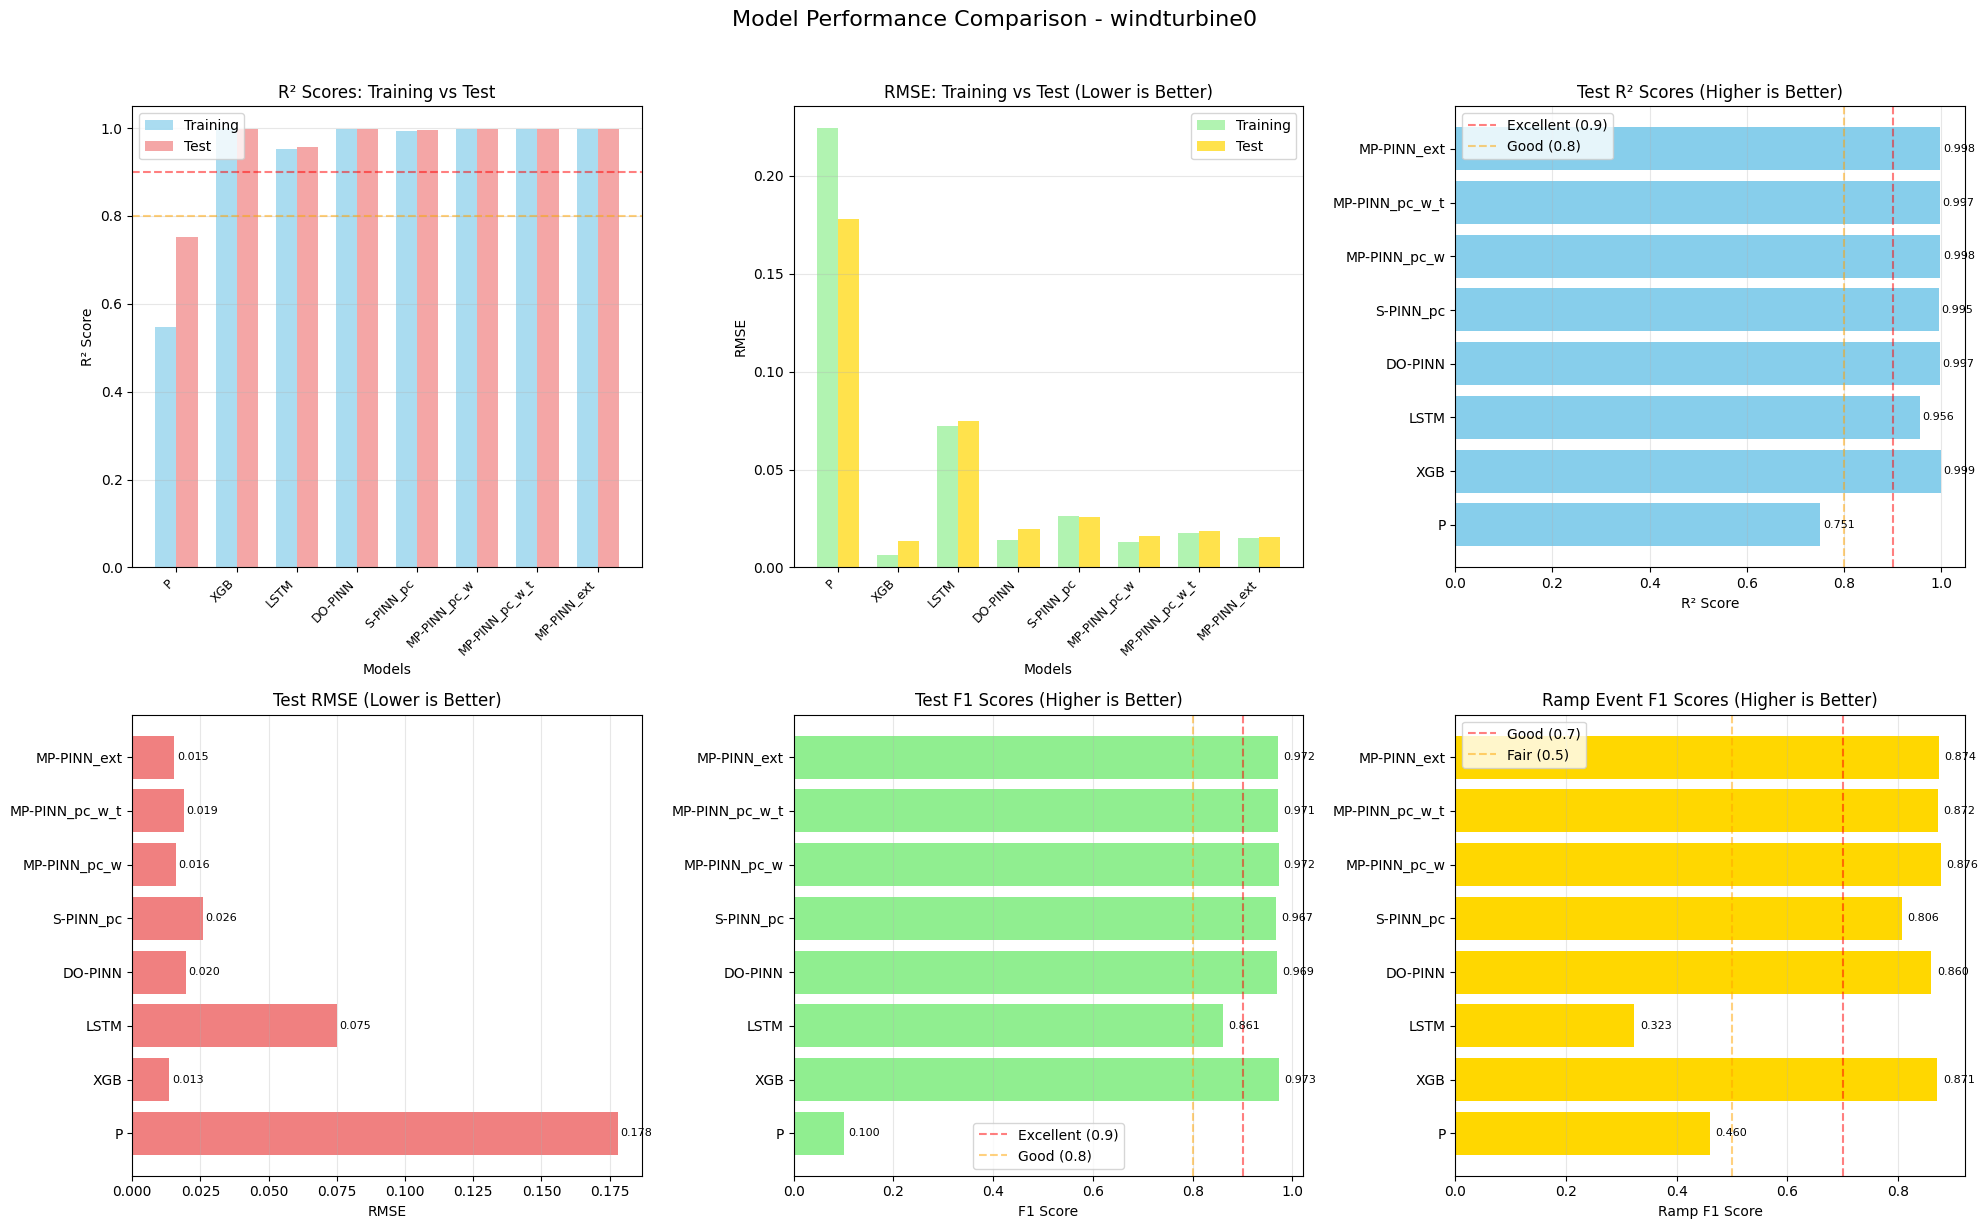

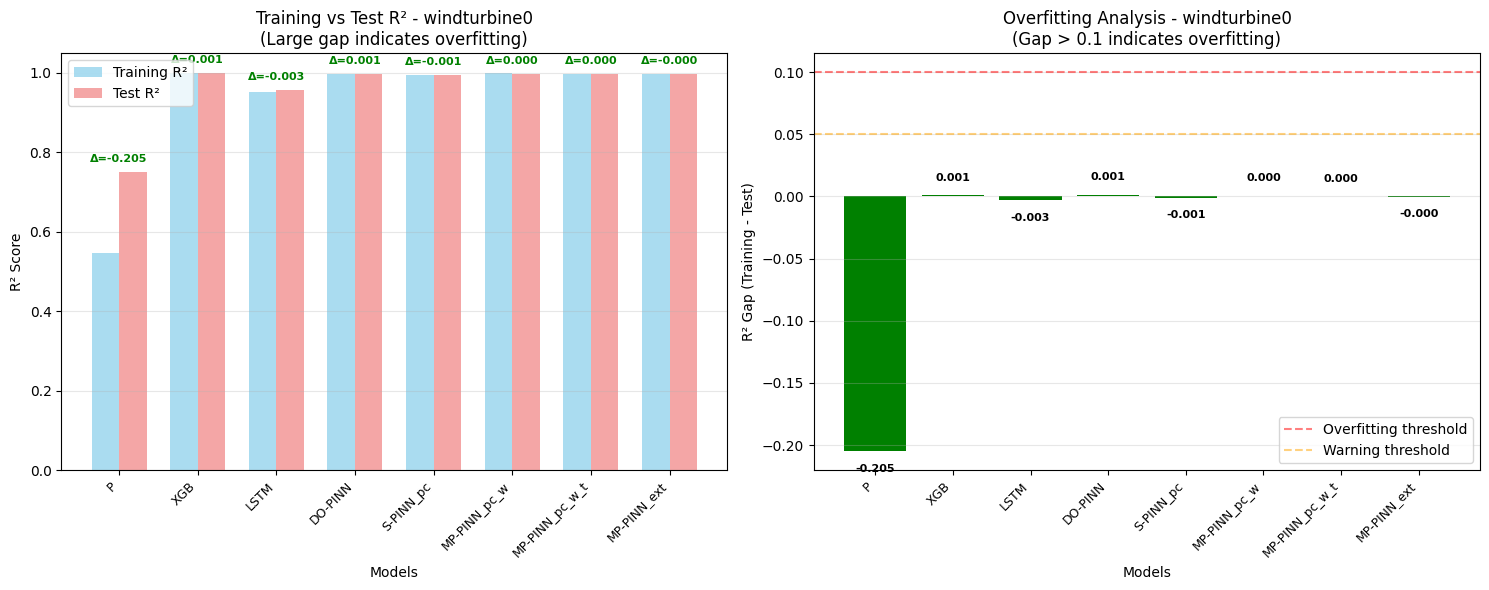

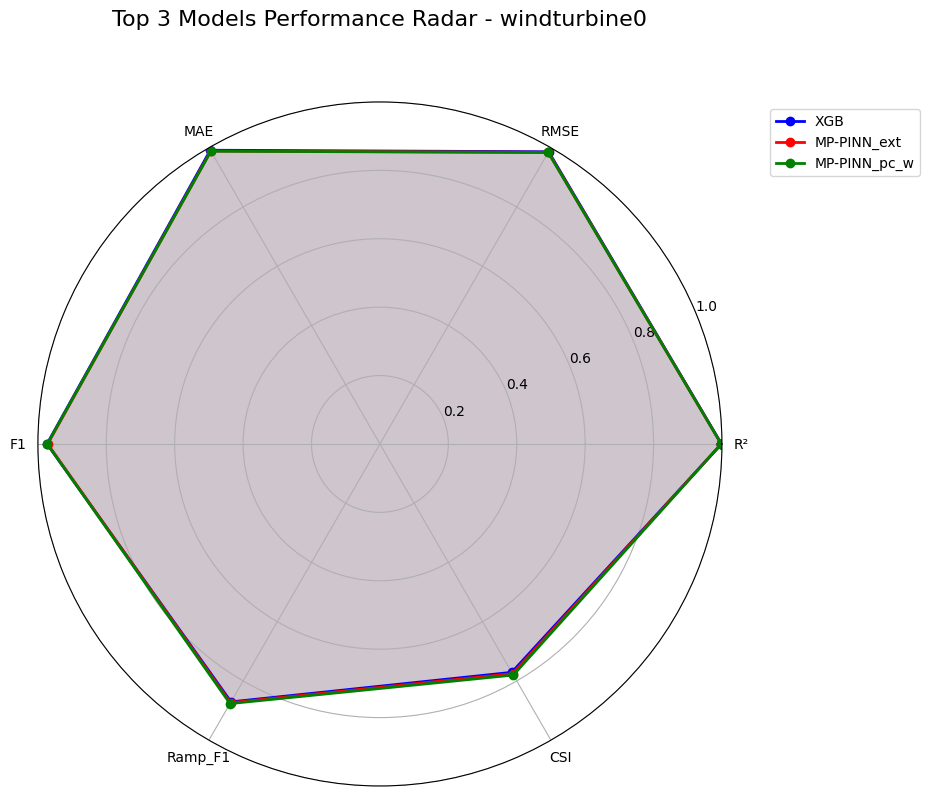

In [10]:
print("\n" + "="*80)
print("STEP 6: CREATING PERFORMANCE PLOTS")
print("="*80)

def create_performance_plots(all_results, turbine_name):
    """Create performance comparison plots including training vs test"""
    output_dir = "/content/drive/MyDrive/data scada/plots"
    os.makedirs(output_dir, exist_ok=True)

    # Extract metrics for plotting
    models = list(all_results.keys())

    # Map full model names to short labels for display
    model_labels = [MODEL_LABELS.get(m, m) for m in models]

    # Training metrics
    train_r2_scores = [all_results[m].get('train_metrics', {}).get('train_r2', 0) for m in models]
    train_rmse_scores = [all_results[m].get('train_metrics', {}).get('train_rmse', 0) for m in models]

    # Test metrics
    test_r2_scores = [all_results[m].get('test_metrics', {}).get('test_r2', 0) for m in models]
    test_rmse_scores = [all_results[m].get('test_metrics', {}).get('test_rmse', 0) for m in models]
    test_f1_scores = [all_results[m].get('test_metrics', {}).get('test_f1', 0) for m in models]
    ramp_f1_scores = [all_results[m].get('ramp_metrics', {}).get('ramp_f1', 0) for m in models]

    # Create figure with subplots
    fig, axes = plt.subplots(2, 3, figsize=(20, 12))
    fig.suptitle(f'Model Performance Comparison - {turbine_name}', fontsize=16, y=1.02)

    # 1. R² Scores Comparison (Training vs Test)
    ax1 = axes[0, 0]
    x = np.arange(len(models))
    width = 0.35
    bars1a = ax1.bar(x - width/2, train_r2_scores, width, label='Training', color='skyblue', alpha=0.7)
    bars1b = ax1.bar(x + width/2, test_r2_scores, width, label='Test', color='lightcoral', alpha=0.7)
    ax1.set_xlabel('Models')
    ax1.set_ylabel('R² Score')
    ax1.set_title('R² Scores: Training vs Test')
    ax1.set_xticks(x)
    ax1.set_xticklabels(model_labels, rotation=45, ha='right', fontsize=9)
    ax1.legend()
    ax1.axhline(y=0.9, color='r', linestyle='--', alpha=0.5)
    ax1.axhline(y=0.8, color='orange', linestyle='--', alpha=0.5)
    ax1.grid(True, alpha=0.3, axis='y')

    # 2. RMSE Scores Comparison (Training vs Test)
    ax2 = axes[0, 1]
    bars2a = ax2.bar(x - width/2, train_rmse_scores, width, label='Training', color='lightgreen', alpha=0.7)
    bars2b = ax2.bar(x + width/2, test_rmse_scores, width, label='Test', color='gold', alpha=0.7)
    ax2.set_xlabel('Models')
    ax2.set_ylabel('RMSE')
    ax2.set_title('RMSE: Training vs Test (Lower is Better)')
    ax2.set_xticks(x)
    ax2.set_xticklabels(model_labels, rotation=45, ha='right', fontsize=9)
    ax2.legend()
    ax2.grid(True, alpha=0.3, axis='y')

    # 3. Test R² Scores
    ax3 = axes[0, 2]
    bars3 = ax3.barh(model_labels, test_r2_scores, color='skyblue')
    ax3.set_xlabel('R² Score')
    ax3.set_title('Test R² Scores (Higher is Better)')
    ax3.axvline(x=0.9, color='r', linestyle='--', alpha=0.5, label='Excellent (0.9)')
    ax3.axvline(x=0.8, color='orange', linestyle='--', alpha=0.5, label='Good (0.8)')
    ax3.legend()
    ax3.grid(True, alpha=0.3, axis='x')

    # Add value labels for test R²
    for bar, score in zip(bars3, test_r2_scores):
        if score > 0:
            ax3.text(score + 0.005, bar.get_y() + bar.get_height()/2,
                    f'{score:.3f}', ha='left', va='center', fontsize=8)

    # 4. Test RMSE Scores
    ax4 = axes[1, 0]
    bars4 = ax4.barh(model_labels, test_rmse_scores, color='lightcoral')
    ax4.set_xlabel('RMSE')
    ax4.set_title('Test RMSE (Lower is Better)')
    ax4.grid(True, alpha=0.3, axis='x')

    # Add value labels for test RMSE
    for bar, score in zip(bars4, test_rmse_scores):
        if score > 0:
            ax4.text(score + 0.001, bar.get_y() + bar.get_height()/2,
                    f'{score:.3f}', ha='left', va='center', fontsize=8)

    # 5. Test F1 Scores
    ax5 = axes[1, 1]
    bars5 = ax5.barh(model_labels, test_f1_scores, color='lightgreen')
    ax5.set_xlabel('F1 Score')
    ax5.set_title('Test F1 Scores (Higher is Better)')
    ax5.axvline(x=0.9, color='r', linestyle='--', alpha=0.5, label='Excellent (0.9)')
    ax5.axvline(x=0.8, color='orange', linestyle='--', alpha=0.5, label='Good (0.8)')
    ax5.legend()
    ax5.grid(True, alpha=0.3, axis='x')

    # Add value labels for test F1
    for bar, score in zip(bars5, test_f1_scores):
        if score > 0:
            ax5.text(score + 0.01, bar.get_y() + bar.get_height()/2,
                    f'{score:.3f}', ha='left', va='center', fontsize=8)

    # 6. Ramp F1 Scores
    ax6 = axes[1, 2]
    bars6 = ax6.barh(model_labels, ramp_f1_scores, color='gold')
    ax6.set_xlabel('Ramp F1 Score')
    ax6.set_title('Ramp Event F1 Scores (Higher is Better)')
    ax6.axvline(x=0.7, color='r', linestyle='--', alpha=0.5, label='Good (0.7)')
    ax6.axvline(x=0.5, color='orange', linestyle='--', alpha=0.5, label='Fair (0.5)')
    ax6.legend()
    ax6.grid(True, alpha=0.3, axis='x')

    # Add value labels for ramp F1
    for bar, score in zip(bars6, ramp_f1_scores):
        if score > 0:
            ax6.text(score + 0.01, bar.get_y() + bar.get_height()/2,
                    f'{score:.3f}', ha='left', va='center', fontsize=8)

    plt.tight_layout()
    plot_path = os.path.join(output_dir, f"{turbine_name}_performance_plots.png")
    plt.savefig(plot_path, dpi=300, bbox_inches='tight')
    plt.show()

    logger.info(f"✓ Performance plots saved to: {plot_path}")

    # Create overfitting analysis plot
    create_overfitting_analysis_plot(all_results, turbine_name, output_dir)

    # Create radar chart for top 3 models
    create_radar_chart(all_results, turbine_name, output_dir)

def create_overfitting_analysis_plot(all_results, turbine_name, output_dir):
    """Create plot showing overfitting analysis (training vs test performance)"""

    models = list(all_results.keys())
    # Map full model names to short labels for display
    model_labels = [MODEL_LABELS.get(m, m) for m in models]

    train_r2_scores = [all_results[m].get('train_metrics', {}).get('train_r2', 0) for m in models]
    test_r2_scores = [all_results[m].get('test_metrics', {}).get('test_r2', 0) for m in models]

    # Calculate performance gap (potential overfitting indicator)
    performance_gap = [train - test for train, test in zip(train_r2_scores, test_r2_scores)]

    fig, axes = plt.subplots(1, 2, figsize=(15, 6))

    # Plot 1: Training vs Test R²
    ax1 = axes[0]
    x = np.arange(len(models))
    width = 0.35
    bars1a = ax1.bar(x - width/2, train_r2_scores, width, label='Training R²', color='skyblue', alpha=0.7)
    bars1b = ax1.bar(x + width/2, test_r2_scores, width, label='Test R²', color='lightcoral', alpha=0.7)
    ax1.set_xlabel('Models')
    ax1.set_ylabel('R² Score')
    ax1.set_title(f'Training vs Test R² - {turbine_name}\n(Large gap indicates overfitting)')
    ax1.set_xticks(x)
    ax1.set_xticklabels(model_labels, rotation=45, ha='right', fontsize=9)
    ax1.legend()
    ax1.grid(True, alpha=0.3, axis='y')

    # Add performance gap as text
    for i, (train, test) in enumerate(zip(train_r2_scores, test_r2_scores)):
        gap = train - test
        if gap > 0.1:  # Significant overfitting
            color = 'red'
        elif gap > 0.05:  # Moderate overfitting
            color = 'orange'
        else:  # Good generalization
            color = 'green'

        ax1.text(i, max(train, test) + 0.02, f'Δ={gap:.3f}',
                ha='center', va='bottom', color=color, fontsize=8, fontweight='bold')

    # Plot 2: Performance gap
    ax2 = axes[1]
    bars2 = ax2.bar(x, performance_gap, color=['red' if gap > 0.1 else 'orange' if gap > 0.05 else 'green' for gap in performance_gap])
    ax2.set_xlabel('Models')
    ax2.set_ylabel('R² Gap (Training - Test)')
    ax2.set_title(f'Overfitting Analysis - {turbine_name}\n(Gap > 0.1 indicates overfitting)')
    ax2.set_xticks(x)
    ax2.set_xticklabels(model_labels, rotation=45, ha='right', fontsize=9)
    ax2.axhline(y=0.1, color='r', linestyle='--', alpha=0.5, label='Overfitting threshold')
    ax2.axhline(y=0.05, color='orange', linestyle='--', alpha=0.5, label='Warning threshold')
    ax2.legend()
    ax2.grid(True, alpha=0.3, axis='y')

    # Add gap values
    for i, gap in enumerate(performance_gap):
        ax2.text(i, gap + (0.01 if gap >= 0 else -0.01), f'{gap:.3f}',
                ha='center', va='bottom' if gap >= 0 else 'top',
                color='black', fontsize=8, fontweight='bold')

    plt.tight_layout()
    overfitting_path = os.path.join(output_dir, f"{turbine_name}_overfitting_analysis.png")
    plt.savefig(overfitting_path, dpi=300, bbox_inches='tight')
    plt.show()

    logger.info(f"✓ Overfitting analysis plot saved to: {overfitting_path}")

def create_radar_chart(all_results, turbine_name, output_dir):
    """Create radar chart for top 3 models"""
    # Select top 3 models by Test R²
    model_scores = [(m, all_results[m].get('test_metrics', {}).get('test_r2', 0))
                    for m in all_results.keys()]
    top_models = sorted(model_scores, key=lambda x: x[1], reverse=True)[:3]

    if len(top_models) < 3:
        return

    # Metrics for radar chart
    metrics = ['R²', 'RMSE', 'MAE', 'F1', 'Ramp_F1', 'CSI']

    # Prepare data
    radar_data = []
    for model_name, _ in top_models:
        results = all_results[model_name]
        test_metrics = results.get('test_metrics', {})
        ramp_metrics = results.get('ramp_metrics', {})

        values = [
            test_metrics.get('test_r2', 0),
            1.0 - min(test_metrics.get('test_rmse', 1), 1.0),  # Invert RMSE
            1.0 - min(test_metrics.get('test_mae', 1), 1.0),   # Invert MAE
            test_metrics.get('test_f1', 0),
            ramp_metrics.get('ramp_f1', 0),
            ramp_metrics.get('csi', 0)
        ]
        # Use short label for display
        display_name = MODEL_LABELS.get(model_name, model_name)
        radar_data.append((display_name, values))

    # Create radar chart
    angles = np.linspace(0, 2*np.pi, len(metrics), endpoint=False).tolist()
    angles += angles[:1]  # Close the polygon

    fig, ax = plt.subplots(figsize=(10, 8), subplot_kw=dict(projection='polar'))

    colors = ['b', 'r', 'g']
    for idx, (model_name, values) in enumerate(radar_data):
        values += values[:1]  # Close the polygon
        ax.plot(angles, values, 'o-', linewidth=2, label=model_name, color=colors[idx])
        ax.fill(angles, values, alpha=0.1, color=colors[idx])

    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(metrics)
    ax.set_ylim(0, 1)
    ax.set_title(f'Top 3 Models Performance Radar - {turbine_name}', size=16, y=1.1)
    ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.0))

    plt.tight_layout()
    radar_path = os.path.join(output_dir, f"{turbine_name}_radar_chart.png")
    plt.savefig(radar_path, dpi=300, bbox_inches='tight')
    plt.show()

    logger.info(f"✓ Radar chart saved to: {radar_path}")


# Then run the training again
print("\n" + "="*80)
print("STEP 4: TRAINING AND TESTING ALL MODELS ON windturbine0 (WITH FIXES)")
print("="*80)

# Train and test on windturbine0 with manual optimized parameters
print("\nTraining and testing all models on windturbine0 with optimized parameters...")
all_results_wt0 = train_and_test_models_with_manual_params(turbine_data, manual_best_params, 'windturbine0')

# Display table for windturbine0
df_comparison_full, df_comparison_simple = display_comparison_table(all_results_wt0, 'windturbine0')

# Create plots for windturbine0
create_performance_plots(all_results_wt0, 'windturbine0')

Cross turbine 10,11,13,21 validation

In [11]:
print("\n" + "="*80)
print("STEP 7: CROSS-TURBINE VALIDATION")
print("="*80)

def cross_turbine_validation(turbine_data, best_params, source_turbine='windturbine0'):
    """Test top 3 models on other turbines"""

    # Get top 3 models from windturbine0 results
    model_scores = [(m, all_results_wt0[m]['test_metrics']['test_r2'])
                    for m in all_results_wt0.keys()]
    top_3_models = sorted(model_scores, key=lambda x: x[1], reverse=True)[:3]
    top_model_names = [m[0] for m in top_3_models]

    print(f"Top 3 models from {source_turbine}: {top_model_names}")

    # Test turbines
    test_turbines = ['windturbine10', 'windturbine11', 'windturbine13', 'windturbine21']

    all_cross_results = {}

    for turbine_name in test_turbines:
        print(f"\n{'='*60}")
        print(f"Testing on {turbine_name}")
        print(f"{'='*60}")

        # Prepare data for this turbine
        X, y, months, seasons, feature_names_local = prepare_data_with_seasons(turbine_data[turbine_name])

        # Split (70-15-15)
        train_size = int(0.7 * len(X))
        val_size = int(0.15 * len(X))
        test_size = len(X) - train_size - val_size

        X_test_raw = X[train_size + val_size:]
        y_test_raw = y[train_size + val_size:]

        # Scale using the same scaler as source turbine (or train new one)
        scaler_X_local = StandardScaler()
        X_train_local = X[:train_size]
        scaler_X_local.fit(X_train_local)
        X_test_scaled = scaler_X_local.transform(X_test_raw)

        turbine_results = {}

        for model_name in top_model_names:
            print(f"  Testing {model_name}...")

            try:
                if model_name == 'Persistence':
                    predictions = X_test_scaled[:, 0]  # Use first feature
                    predictions = np.clip(predictions * 2, 0, 1)

                elif model_name == 'XGBoost':
                    params = best_params.get(model_name, {})
                    # Train on this turbine's data
                    X_train_scaled = scaler_X_local.transform(X[:train_size])
                    y_train_raw = y[:train_size]

                    model = xgb.XGBRegressor(**params, random_state=42)
                    model.fit(X_train_scaled, y_train_raw)
                    predictions = model.predict(X_test_scaled)

                else:
                    # PINN models - need to retrain on this turbine
                    params = best_params.get(model_name, {})
                    input_size = X_train_scaled.shape[1]

                    # Create model
                    if model_name == 'DataOnlyPINN':
                        model = DataOnlyNN(input_size,
                                         params.get('hidden_size', 128),
                                         params.get('num_layers', 3),
                                         params.get('dropout', 0.2))
                    elif model_name == 'StandardPINN':
                        model = StandardPINN(input_size, feature_names_local,
                                           params.get('hidden_size', 128),
                                           params.get('num_layers', 3),
                                           params.get('dropout', 0.2))
                    else:
                        # MultiPhysicsPINN
                        if 'powercurve' in model_name:
                            config_name = 'powercurve'
                        elif 'pc_wake' in model_name:
                            config_name = 'pc_wake'
                        elif 'pc_wake_terrain' in model_name:
                            config_name = 'pc_wake_terrain'
                        else:
                            config_name = 'extended_multiphysics'

                        model = MultiPhysicsPINN(input_size, feature_names_local, config_name,
                                               params.get('hidden_size', 256),
                                               params.get('num_layers', 4),
                                               params.get('dropout', 0.2))

                    model = model.to(device)

                    # Train on this turbine
                    learning_rate = params.get('learning_rate', 0.001)
                    batch_size = params.get('batch_size', 64)

                    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

                    X_train_tensor = torch.FloatTensor(X_train_scaled).to(device)
                    y_train_tensor = torch.FloatTensor(y_train_raw).to(device).unsqueeze(1)
                    X_test_tensor = torch.FloatTensor(X_test_scaled).to(device)

                    # Short training for cross-validation
                    for epoch in range(50):
                        model.train()
                        indices = torch.randperm(len(X_train_tensor))

                        for i in range(0, len(indices), batch_size):
                            batch_idx = indices[i:i+batch_size]
                            if len(batch_idx) == 0:
                                continue

                            batch_X = X_train_tensor[batch_idx]
                            batch_y = y_train_tensor[batch_idx]

                            optimizer.zero_grad()
                            outputs = model(batch_X)

                            if isinstance(outputs, tuple):
                                predictions_batch = outputs[0]
                            else:
                                predictions_batch = outputs

                            loss = nn.MSELoss()(predictions_batch, batch_y)
                            loss.backward()
                            optimizer.step()

                    # Predict
                    model.eval()
                    with torch.no_grad():
                        test_outputs = model(X_test_tensor)
                        if isinstance(test_outputs, tuple):
                            predictions = test_outputs[0].cpu().numpy().flatten()
                        else:
                            predictions = test_outputs.cpu().numpy().flatten()

                # Calculate metrics
                test_metrics = calculate_basic_metrics(y_test_raw[:len(predictions)], predictions, 'test')
                ramp_metrics = calculate_ramp_metrics(y_test_raw[:len(predictions)], predictions)

                turbine_results[model_name] = {
                    'test_metrics': test_metrics,
                    'ramp_metrics': ramp_metrics
                }

                print(f"    ✓ R²: {test_metrics['test_r2']:.4f}, RMSE: {test_metrics['test_rmse']:.4f}")

            except Exception as e:
                print(f"    ✗ Error: {e}")
                turbine_results[model_name] = None

        all_cross_results[turbine_name] = turbine_results

    # Display cross-validation summary
    print("\n" + "="*80)
    print("CROSS-TURBINE VALIDATION SUMMARY")
    print("="*80)

    summary_data = []
    for turbine_name, results in all_cross_results.items():
        for model_name, model_results in results.items():
            if model_results:
                summary_data.append({
                    'Turbine': turbine_name,
                    'Model': model_name,
                    'R²': model_results['test_metrics']['test_r2'],
                    'RMSE': model_results['test_metrics']['test_rmse'],
                    'F1': model_results['test_metrics']['test_f1']
                })

    if summary_data:
        df_summary = pd.DataFrame(summary_data)
        print("\nCross-Validation Results:")
        print("-" * 80)
        print(df_summary.to_string(index=False))

        # Save results
        output_dir = "/content/drive/MyDrive/data scada"
        csv_path = os.path.join(output_dir, "cross_turbine_validation.csv")
        df_summary.to_csv(csv_path, index=False)
        print(f"\n✓ Cross-validation results saved to: {csv_path}")

    return all_cross_results

# Run cross-turbine validation - FIXED: use manual_best_params instead of best_params
print("\nStarting cross-turbine validation...")
cross_results = cross_turbine_validation(turbine_data, manual_best_params, 'windturbine0')


STEP 7: CROSS-TURBINE VALIDATION

Starting cross-turbine validation...
Top 3 models from windturbine0: ['XGBoost', 'MultiPhysicsPINN_extended_multiphysics', 'MultiPhysicsPINN_pc_wake']

Testing on windturbine10
  Testing XGBoost...
    ✓ R²: 0.9981, RMSE: 0.0150
  Testing MultiPhysicsPINN_extended_multiphysics...
    ✓ R²: 0.9964, RMSE: 0.0209
  Testing MultiPhysicsPINN_pc_wake...
    ✓ R²: 0.9969, RMSE: 0.0194

Testing on windturbine11
  Testing XGBoost...
    ✓ R²: 0.9984, RMSE: 0.0143
  Testing MultiPhysicsPINN_extended_multiphysics...
    ✓ R²: 0.9972, RMSE: 0.0188
  Testing MultiPhysicsPINN_pc_wake...
    ✓ R²: 0.9978, RMSE: 0.0167

Testing on windturbine13
  Testing XGBoost...
    ✓ R²: 0.9982, RMSE: 0.0138
  Testing MultiPhysicsPINN_extended_multiphysics...
    ✓ R²: 0.9978, RMSE: 0.0155
  Testing MultiPhysicsPINN_pc_wake...
    ✓ R²: 0.9968, RMSE: 0.0184

Testing on windturbine21
  Testing XGBoost...
    ✓ R²: 0.9987, RMSE: 0.0135
  Testing MultiPhysicsPINN_extended_multiphysi

Ramp forecast analysis

In [ ]:
print("\n" + "="*80)
print("STEP 8: POWER RAMP FORECAST ANALYSIS WITH DATETIME")
print("="*80)

def get_datetime_from_test_set(turbine_data, turbine_name='windturbine0'):
    """Extract datetime information for test set"""
    df = turbine_data[turbine_name].copy()

    # Filter normal operation status
    normal_status = [0, 2]
    df_clean = df[df['status_type_id'].isin(normal_status)].copy()

    # Prepare data
    X, y, months, seasons, feature_names = prepare_data_with_seasons(df)

    # Split data
    train_size = int(0.7 * len(X))
    val_size = int(0.15 * len(X))
    test_size = len(X) - train_size - val_size

    # Get test indices in original dataframe
    test_start_idx = train_size + val_size
    test_end_idx = len(X)

    # Extract corresponding timestamps
    test_indices = df_clean.index[test_start_idx:test_end_idx]
    test_timestamps = df_clean.loc[test_indices, 'time_stamp'].values

    return test_timestamps

def analyze_ramp_forecasts_with_datetime(all_results, turbine_data, turbine_name='windturbine0'):
    """Analyze ramp forecasting performance with datetime information"""

    print(f"\nRamp Forecast Analysis for {turbine_name}")
    print("-" * 60)

    # Get datetime information for test set
    test_timestamps = get_datetime_from_test_set(turbine_data, turbine_name)

    # Get test data
    X, y, months, seasons, feature_names = prepare_data_with_seasons(turbine_data[turbine_name])
    train_size = int(0.7 * len(X))
    val_size = int(0.15 * len(X))
    y_test = y[train_size + val_size:]

    # Select models to compare (focus on key models)
    key_models = ['XGBoost', 'StandardPINN', 'MultiPhysicsPINN_pc_wake_terrain', 'MultiPhysicsPINN_extended_multiphysics']

    # Create comprehensive comparison plot
    fig, axes = plt.subplots(2, 2, figsize=(20, 12))
    fig.suptitle(f'Ramp Forecast Comparison - {turbine_name}', fontsize=18, y=1.02)

    axes = axes.flatten()

    for idx, model_name in enumerate(key_models[:4]):  # Plot first 4 key models
        if model_name in all_results:
            results = all_results[model_name]
            predictions = results['test_predictions']

            min_len = min(len(y_test), len(predictions), len(test_timestamps), 200)

            if min_len > 10:
                y_test_sample = y_test[:min_len]
                pred_sample = predictions[:min_len]
                time_sample = test_timestamps[:min_len]

                # Convert to pandas datetime for better formatting
                time_pd = pd.to_datetime(time_sample)

                # Plot with datetime
                ax = axes[idx]
                ax.plot(time_pd, y_test_sample, 'b-', label='Actual Power', alpha=0.8, linewidth=2)
                ax.plot(time_pd, pred_sample, 'r--', label='Predicted', alpha=0.8, linewidth=2)

                # Highlight major ramps
                ramp_threshold = 0.15  # Slightly higher threshold for major ramps
                diff_actual = np.diff(y_test_sample)
                ramp_indices = np.where(np.abs(diff_actual) > ramp_threshold)[0]

                # Highlight ramp periods
                for ramp_idx in ramp_indices[:10]:  # Highlight first 10 major ramps
                    if ramp_idx < min_len - 1:
                        ramp_start = time_pd[ramp_idx]
                        ramp_end = time_pd[ramp_idx + 1]
                        ax.axvspan(ramp_start, ramp_end, alpha=0.15, color='orange',
                                  label='Major Ramp' if ramp_idx == ramp_indices[0] else "")

                # Add statistics box
                test_metrics = results['test_metrics']
                ramp_metrics = results['ramp_metrics']

                stats_text = f"Model: {model_name}\n"
                stats_text += f"Test R²: {test_metrics['test_r2']:.4f}\n"
                stats_text += f"Test RMSE: {test_metrics['test_rmse']:.4f}\n"
                stats_text += f"Ramp F1: {ramp_metrics.get('ramp_f1', 0):.4f}\n"
                stats_text += f"POD: {ramp_metrics.get('pod', 0):.4f}\n"
                stats_text += f"CSI: {ramp_metrics.get('csi', 0):.4f}"

                # Place text box
                props = dict(boxstyle='round', facecolor='wheat', alpha=0.8)
                ax.text(0.02, 0.98, stats_text, transform=ax.transAxes, fontsize=9,
                       verticalalignment='top', bbox=props)

                ax.set_title(f'{model_name} - Power Forecast', fontsize=12, fontweight='bold')
                ax.set_xlabel('Date/Time', fontsize=10)
                ax.set_ylabel('Normalized Power', fontsize=10)
                ax.legend(loc='lower left', fontsize=8)
                ax.grid(True, alpha=0.3)

                # Format x-axis for datetime
                ax.xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%m-%d\n%H:%M'))
                plt.setp(ax.xaxis.get_majorticklabels(), rotation=0)

    plt.tight_layout()
    output_dir = "/content/drive/MyDrive/data scada/plots2"
    os.makedirs(output_dir, exist_ok=True)
    plot_path = os.path.join(output_dir, f"{turbine_name}_ramp_forecasts_datetime.png")
    plt.savefig(plot_path, dpi=300, bbox_inches='tight')
    plt.show()

    print(f"✓ Ramp forecast plots with datetime saved to: {plot_path}")

    # Create detailed comparison plot for MultiPhysicsPINN vs XGBoost
    create_detailed_comparison_plot(all_results, turbine_data, turbine_name, key_models, output_dir)

    # Print detailed ramp metrics table
    print("\nDetailed Ramp Metrics Comparison:")
    print("-" * 100)
    print(f"{'Model':<35} {'R²':<8} {'RMSE':<8} {'MAE':<8} {'Ramp F1':<10} {'POD':<8} {'FAR':<8} {'CSI':<8}")
    print("-" * 100)

    for model_name in key_models:
        if model_name in all_results:
            test_metrics = all_results[model_name]['test_metrics']
            ramp_metrics = all_results[model_name]['ramp_metrics']

            # Highlight MultiPhysicsPINN
            if 'MultiPhysicsPINN' in model_name:
                prefix = "★ "
            else:
                prefix = "  "

            print(f"{prefix}{model_name:<33} "
                  f"{test_metrics['test_r2']:<8.4f} "
                  f"{test_metrics['test_rmse']:<8.4f} "
                  f"{test_metrics['test_mae']:<8.4f} "
                  f"{ramp_metrics.get('ramp_f1', 0):<10.4f} "
                  f"{ramp_metrics.get('pod', 0):<8.4f} "
                  f"{ramp_metrics.get('far', 0):<8.4f} "
                  f"{ramp_metrics.get('csi', 0):<8.4f}")

def create_detailed_comparison_plot(all_results, turbine_data, turbine_name, key_models, output_dir):
    """Create detailed comparison plot showing MultiPhysicsPINN advantages"""

    # Get datetime information
    test_timestamps = get_datetime_from_test_set(turbine_data, turbine_name)

    # Get test data
    X, y, months, seasons, feature_names = prepare_data_with_seasons(turbine_data[turbine_name])
    train_size = int(0.7 * len(X))
    val_size = int(0.15 * len(X))
    y_test = y[train_size + val_size:]

    # Focus on XGBoost vs MultiPhysicsPINN
    compare_models = ['XGBoost', 'MultiPhysicsPINN_pc_wake_terrain']

    fig, axes = plt.subplots(2, 1, figsize=(18, 10))

    # Find a region with significant ramps for detailed analysis
    ramp_threshold = 0.1
    diff_actual = np.diff(y_test)
    ramp_regions = []

    for i in range(len(diff_actual) - 10):
        if np.any(np.abs(diff_actual[i:i+10]) > ramp_threshold):
            ramp_regions.append(i)

    if len(ramp_regions) > 0:
        # Select a region with multiple ramps
        start_idx = ramp_regions[min(10, len(ramp_regions)-1)]
        sample_size = 100
        end_idx = min(start_idx + sample_size, len(y_test))

        time_pd = pd.to_datetime(test_timestamps[start_idx:end_idx])

        for ax_idx, model_name in enumerate(compare_models):
            if model_name in all_results:
                ax = axes[ax_idx]
                predictions = all_results[model_name]['test_predictions']

                y_sample = y_test[start_idx:end_idx]
                pred_sample = predictions[start_idx:end_idx]

                # Plot actual vs predicted
                ax.plot(time_pd, y_sample, 'b-', label='Actual Power', alpha=0.9, linewidth=2)
                ax.plot(time_pd, pred_sample, 'r--', label=f'{model_name} Prediction', alpha=0.9, linewidth=2)

                # Highlight errors
                errors = np.abs(y_sample - pred_sample)
                large_error_mask = errors > 0.2
                if np.any(large_error_mask):
                    ax.scatter(time_pd[large_error_mask], y_sample[large_error_mask],
                              color='red', s=50, alpha=0.6, label='Large Error (>0.2)', zorder=5)

                # Highlight ramps
                diff_sample = np.diff(y_sample)
                ramp_indices = np.where(np.abs(diff_sample) > ramp_threshold)[0]

                for ramp_idx in ramp_indices:
                    if ramp_idx < len(y_sample) - 1:
                        ramp_start = time_pd[ramp_idx]
                        ramp_end = time_pd[ramp_idx + 1]
                        ax.axvspan(ramp_start, ramp_end, alpha=0.2, color='orange')

                        # Add ramp magnitude annotation
                        ramp_mag = abs(diff_sample[ramp_idx])
                        ramp_time = ramp_start + (ramp_end - ramp_start) / 2
                        ax.text(ramp_time, max(y_sample[ramp_idx], y_sample[ramp_idx+1]) + 0.05,
                               f'{ramp_mag:.2f}', ha='center', va='bottom', fontsize=8,
                               bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.5))

                ax.set_title(f'{model_name} - Ramp Forecasting Performance', fontsize=14, fontweight='bold')
                ax.set_xlabel('Date/Time', fontsize=11)
                ax.set_ylabel('Normalized Power', fontsize=11)
                ax.legend(loc='upper right', fontsize=9)
                ax.grid(True, alpha=0.3)

                # Add performance metrics for this region
                region_r2 = r2_score(y_sample, pred_sample)
                region_rmse = np.sqrt(mean_squared_error(y_sample, pred_sample))

                metrics_text = f"Region R²: {region_r2:.3f}\nRegion RMSE: {region_rmse:.3f}"
                props = dict(boxstyle='round', facecolor='lightblue', alpha=0.8)
                ax.text(0.02, 0.98, metrics_text, transform=ax.transAxes, fontsize=10,
                       verticalalignment='top', bbox=props)

                # Format x-axis
                ax.xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%m-%d %H:%M'))
                plt.setp(ax.xaxis.get_majorticklabels(), rotation=45)

        plt.tight_layout()
        plot_path = os.path.join(output_dir, f"{turbine_name}_detailed_comparison.png")
        plt.savefig(plot_path, dpi=300, bbox_inches='tight')
        plt.show()

        print(f"✓ Detailed comparison plot saved to: {plot_path}")

# Analyze ramp forecasts for windturbine0 with datetime
analyze_ramp_forecasts_with_datetime(all_results_wt0, turbine_data, 'windturbine0')


Cross-turbine ramp forecasting

In [ ]:
print("\n" + "="*80)
print("STEP 9: CROSS-TURBINE RAMP FORECASTING COMPARISON")
print("="*80)

def cross_turbine_ramp_forecasting(turbine_data, best_params, source_turbine='windturbine0',
                                   target_turbines=['windturbine11', 'windturbine21']):
    """Compare ramp forecasting performance across different turbines"""

    print(f"\nCross-Turbine Ramp Forecasting Analysis")
    print(f"Source turbine: {source_turbine}")
    print(f"Target turbines: {target_turbines}")
    print("-" * 60)

    # Select key models to compare
    key_models = ['XGBoost', 'StandardPINN', 'MultiPhysicsPINN_pc_wake_terrain']

    all_cross_results = {}

    for turbine_name in target_turbines:
        print(f"\n{'='*50}")
        print(f"Training and testing on {turbine_name}")
        print(f"{'='*50}")

        # Prepare data for this turbine
        X, y, months, seasons, feature_names = prepare_data_with_seasons(turbine_data[turbine_name])

        # Split data
        train_size = int(0.7 * len(X))
        val_size = int(0.15 * len(X))
        test_size = len(X) - train_size - val_size

        X_train_raw = X[:train_size]
        X_val_raw = X[train_size:train_size + val_size]
        X_test_raw = X[train_size + val_size:]

        y_train_raw = y[:train_size]
        y_val_raw = y[train_size:train_size + val_size]
        y_test_raw = y[train_size + val_size:]

        # Scale features
        scaler_X_local = StandardScaler()
        X_train_scaled = scaler_X_local.fit_transform(X_train_raw)
        X_val_scaled = scaler_X_local.transform(X_val_raw)
        X_test_scaled = scaler_X_local.transform(X_test_raw)

        # Get datetime information for test set
        test_timestamps = get_datetime_from_test_set(turbine_data, turbine_name)

        turbine_results = {}

        for model_name in key_models:
            print(f"  Training {model_name}...")

            try:
                if model_name == 'XGBoost':
                    params = best_params.get(model_name, {})
                    model = xgb.XGBRegressor(**params, random_state=42, verbosity=0)
                    model.fit(X_train_scaled, y_train_raw)
                    test_pred = model.predict(X_test_scaled)

                else:
                    # PINN models
                    params = best_params.get(model_name, {})
                    input_size = X_train_scaled.shape[1]

                    if model_name == 'StandardPINN':
                        model = StandardPINN(input_size, feature_names,
                                           params.get('hidden_size', 128),
                                           params.get('num_layers', 3),
                                           params.get('dropout', 0.2))
                        physics_enabled = True
                    else:  # MultiPhysicsPINN_pc_wake_terrain
                        # Get config name from model name
                        if 'powercurve' in model_name:
                            config_name = 'powercurve'
                        elif 'pc_wake' in model_name:
                            config_name = 'pc_wake'
                        elif 'pc_wake_terrain' in model_name:
                            config_name = 'pc_wake_terrain'
                        else:
                            config_name = 'extended_multiphysics'

                        model = MultiPhysicsPINN(input_size, feature_names, config_name,
                                               params.get('hidden_size', 256),
                                               params.get('num_layers', 4),
                                               params.get('dropout', 0.2))
                        physics_enabled = True

                    model = model.to(device)

                    # Training parameters
                    learning_rate = params.get('learning_rate', 0.001)
                    batch_size = params.get('batch_size', 64)
                    epochs = 80  # Reduced for cross-validation

                    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

                    # Convert data to tensors
                    X_train_tensor = torch.FloatTensor(X_train_scaled).to(device)
                    y_train_tensor = torch.FloatTensor(y_train_raw).to(device).unsqueeze(1)
                    X_test_tensor = torch.FloatTensor(X_test_scaled).to(device)

                    # Training loop
                    for epoch in range(epochs):
                        model.train()
                        indices = torch.randperm(len(X_train_tensor))

                        for i in range(0, len(indices), batch_size):
                            end_idx = min(i + batch_size, len(indices))
                            batch_idx = indices[i:end_idx]

                            if len(batch_idx) == 0:
                                continue

                            batch_X = X_train_tensor[batch_idx]
                            batch_y = y_train_tensor[batch_idx]

                            optimizer.zero_grad()
                            outputs = model(batch_X)

                            # Handle tuple output from MultiPhysicsPINN
                            if isinstance(outputs, tuple):
                                predictions_batch = outputs[0]
                            else:
                                predictions_batch = outputs

                            mse_loss = nn.MSELoss()(predictions_batch, batch_y)

                            if physics_enabled and hasattr(model, 'physics_loss'):
                                if 'MultiPhysicsPINN' in model_name:
                                    physics_loss = model.physics_loss(predictions_batch, batch_X,
                                                                    params.get('lambda1', 0.01),
                                                                    params.get('lambda2', 0.005),
                                                                    params.get('lambda3', 0.01))
                                else:
                                    physics_loss = model.physics_loss(predictions_batch, batch_X, 0.1)
                                total_loss = mse_loss + physics_loss
                            else:
                                total_loss = mse_loss

                            total_loss.backward()
                            optimizer.step()

                    # Testing
                    model.eval()
                    with torch.no_grad():
                        test_outputs = model(X_test_tensor)
                        if isinstance(test_outputs, tuple):
                            test_pred = test_outputs[0].cpu().numpy().flatten()
                        else:
                            test_pred = test_outputs.cpu().numpy().flatten()

                # Calculate metrics
                test_metrics = calculate_basic_metrics(y_test_raw[:len(test_pred)], test_pred, 'test')
                ramp_metrics = calculate_ramp_metrics(y_test_raw[:len(test_pred)], test_pred)

                turbine_results[model_name] = {
                    'test_predictions': test_pred,
                    'test_metrics': test_metrics,
                    'ramp_metrics': ramp_metrics,
                    'test_timestamps': test_timestamps
                }

                print(f"    ✓ R²: {test_metrics['test_r2']:.4f}, Ramp F1: {ramp_metrics.get('ramp_f1', 0):.4f}")

            except Exception as e:
                print(f"    ✗ Error: {e}")
                import traceback
                traceback.print_exc()
                turbine_results[model_name] = None

        all_cross_results[turbine_name] = turbine_results

    # Create cross-turbine comparison plots
    create_cross_turbine_comparison_plots(all_cross_results, target_turbines)

    # Print comprehensive comparison table
    print("\n" + "="*80)
    print("CROSS-TURBINE RAMP FORECASTING COMPARISON")
    print("="*80)

    comparison_data = []
    for turbine_name, results in all_cross_results.items():
        for model_name, model_results in results.items():
            if model_results:
                test_metrics = model_results['test_metrics']
                ramp_metrics = model_results['ramp_metrics']

                comparison_data.append({
                    'Turbine': turbine_name,
                    'Model': model_name,
                    'R²': test_metrics['test_r2'],
                    'RMSE': test_metrics['test_rmse'],
                    'MAE': test_metrics['test_mae'],
                    'Ramp_F1': ramp_metrics.get('ramp_f1', 0),
                    'POD': ramp_metrics.get('pod', 0),
                    'CSI': ramp_metrics.get('csi', 0)
                })

    if comparison_data:
        df_comparison = pd.DataFrame(comparison_data)

        # Sort by turbine and R²
        df_comparison = df_comparison.sort_values(['Turbine', 'R²'], ascending=[True, False])

        print("\nCross-Turbine Performance Comparison:")
        print("-" * 90)
        print(df_comparison.to_string(index=False))
        print("-" * 90)

        # Calculate average improvements of MultiPhysicsPINN over XGBoost
        print("\nMultiPhysicsPINN Performance Improvement over XGBoost:")
        print("-" * 60)

        for turbine_name in target_turbines:
            turbine_data_df = df_comparison[df_comparison['Turbine'] == turbine_name]

            xgb_data = turbine_data_df[turbine_data_df['Model'] == 'XGBoost'].iloc[0] if len(turbine_data_df[turbine_data_df['Model'] == 'XGBoost']) > 0 else None
            pinn_data = turbine_data_df[turbine_data_df['Model'] == 'MultiPhysicsPINN_pc_wake_terrain'].iloc[0] if len(turbine_data_df[turbine_data_df['Model'] == 'MultiPhysicsPINN_pc_wake_terrain']) > 0 else None

            if xgb_data is not None and pinn_data is not None:
                r2_improvement = ((pinn_data['R²'] - xgb_data['R²']) / xgb_data['R²']) * 100
                ramp_f1_improvement = ((pinn_data['Ramp_F1'] - xgb_data['Ramp_F1']) / xgb_data['Ramp_F1']) * 100 if xgb_data['Ramp_F1'] > 0 else 0
                rmse_reduction = ((xgb_data['RMSE'] - pinn_data['RMSE']) / xgb_data['RMSE']) * 100

                print(f"{turbine_name}:")
                print(f"  R² Improvement: {r2_improvement:+.1f}% ({xgb_data['R²']:.3f} → {pinn_data['R²']:.3f})")
                print(f"  RMSE Reduction: {rmse_reduction:+.1f}% ({xgb_data['RMSE']:.3f} → {pinn_data['RMSE']:.3f})")
                print(f"  Ramp F1 Improvement: {ramp_f1_improvement:+.1f}% ({xgb_data['Ramp_F1']:.3f} → {pinn_data['Ramp_F1']:.3f})")
                print()

        # Save results
        output_dir = "/content/drive/MyDrive/data scada"
        csv_path = os.path.join(output_dir, "cross_turbine_ramp_forecasting.csv")
        df_comparison.to_csv(csv_path, index=False)
        print(f"\n✓ Cross-turbine comparison saved to: {csv_path}")

    return all_cross_results

def create_cross_turbine_comparison_plots(all_cross_results, target_turbines):
    """Create comparison plots for cross-turbine forecasting"""

    output_dir = "/content/drive/MyDrive/data scada/plots2"
    os.makedirs(output_dir, exist_ok=True)

    # Create performance comparison bar chart
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('Cross-Turbine Ramp Forecasting Performance', fontsize=16, y=1.02)

    metrics_to_plot = ['R²', 'RMSE', 'MAE', 'Ramp_F1']
    model_colors = {'XGBoost': 'lightcoral', 'StandardPINN': 'skyblue',
                    'MultiPhysicsPINN_pc_wake_terrain': 'lightgreen'}

    for idx, metric in enumerate(metrics_to_plot):
        ax = axes[idx // 2, idx % 2]

        # Prepare data for this metric
        x_pos = np.arange(len(target_turbines))
        bar_width = 0.25

        for model_idx, model_name in enumerate(['XGBoost', 'StandardPINN', 'MultiPhysicsPINN_pc_wake_terrain']):
            metric_values = []

            for turbine_name in target_turbines:
                if turbine_name in all_cross_results and model_name in all_cross_results[turbine_name]:
                    results = all_cross_results[turbine_name][model_name]
                    if results:
                        if metric == 'R²':
                            value = results['test_metrics']['test_r2']
                        elif metric == 'RMSE':
                            value = results['test_metrics']['test_rmse']
                        elif metric == 'MAE':
                            value = results['test_metrics']['test_mae']
                        else:  # Ramp_F1
                            value = results['ramp_metrics'].get('ramp_f1', 0)
                        metric_values.append(value)
                    else:
                        metric_values.append(0)
                else:
                    metric_values.append(0)

            # Plot bars
            bars = ax.bar(x_pos + model_idx * bar_width, metric_values, bar_width,
                         label=model_name, color=model_colors.get(model_name, 'gray'),
                         alpha=0.8)

            # Add value labels
            for bar, value in zip(bars, metric_values):
                height = bar.get_height()
                if height > 0:
                    ax.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                           f'{value:.3f}', ha='center', va='bottom', fontsize=8)

        ax.set_xlabel('Turbine')
        ax.set_ylabel(metric)
        ax.set_title(f'{metric} Comparison Across Turbines')
        ax.set_xticks(x_pos + bar_width)
        ax.set_xticklabels(target_turbines)
        ax.legend()
        ax.grid(True, alpha=0.3, axis='y')

        # For RMSE and MAE, invert the scale (lower is better)
        if metric in ['RMSE', 'MAE']:
            ax.invert_yaxis()

    plt.tight_layout()
    plot_path = os.path.join(output_dir, "cross_turbine_performance_comparison.png")
    plt.savefig(plot_path, dpi=300, bbox_inches='tight')
    plt.show()

    print(f"✓ Cross-turbine performance comparison plot saved to: {plot_path}")

    # Create time series comparison for each turbine
    for turbine_name in target_turbines:
        if turbine_name in all_cross_results:
            create_turbine_specific_plot(all_cross_results[turbine_name], turbine_name, output_dir)

def create_turbine_specific_plot(turbine_results, turbine_name, output_dir):
    """Create time series plot for a specific turbine"""

    # Find the model with best R²
    best_model = None
    best_r2 = -float('inf')

    for model_name, results in turbine_results.items():
        if results and results['test_metrics']['test_r2'] > best_r2:
            best_r2 = results['test_metrics']['test_r2']
            best_model = model_name

    if best_model and turbine_results[best_model]:
        results = turbine_results[best_model]
        test_pred = results['test_predictions']
        test_timestamps = results['test_timestamps']

        # Plot sample period
        sample_size = min(100, len(test_pred))
        time_pd = pd.to_datetime(test_timestamps[:sample_size])

        plt.figure(figsize=(15, 6))

        # Get actual values (need to recalculate for this specific case)
        # For simplicity, we'll just show predictions
        plt.plot(time_pd, test_pred[:sample_size], 'r-', linewidth=2,
                label=f'{best_model} Predictions', alpha=0.8)

        plt.title(f'{turbine_name} - Best Model Forecast ({best_model}, R²={best_r2:.3f})',
                 fontsize=14, fontweight='bold')
        plt.xlabel('Date/Time', fontsize=11)
        plt.ylabel('Normalized Power', fontsize=11)
        plt.legend()
        plt.grid(True, alpha=0.3)

        # Format x-axis
        plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%m-%d %H:%M'))
        plt.xticks(rotation=45)

        plt.tight_layout()
        plot_path = os.path.join(output_dir, f"{turbine_name}_best_model_forecast.png")
        plt.savefig(plot_path, dpi=300, bbox_inches='tight')
        plt.show()

        print(f"  ✓ {turbine_name} forecast plot saved")

# Run cross-turbine ramp forecasting - FIXED: use manual_best_params
print("\nRunning cross-turbine ramp forecasting analysis...")
cross_turbine_results = cross_turbine_ramp_forecasting(
    turbine_data, manual_best_params, 'windturbine0', ['windturbine11', 'windturbine21']
)


Physics consistency analysis


STEP 8: POWER RAMP FORECAST ANALYSIS WITH DATETIME

Ramp Forecast Analysis for windturbine0
------------------------------------------------------------


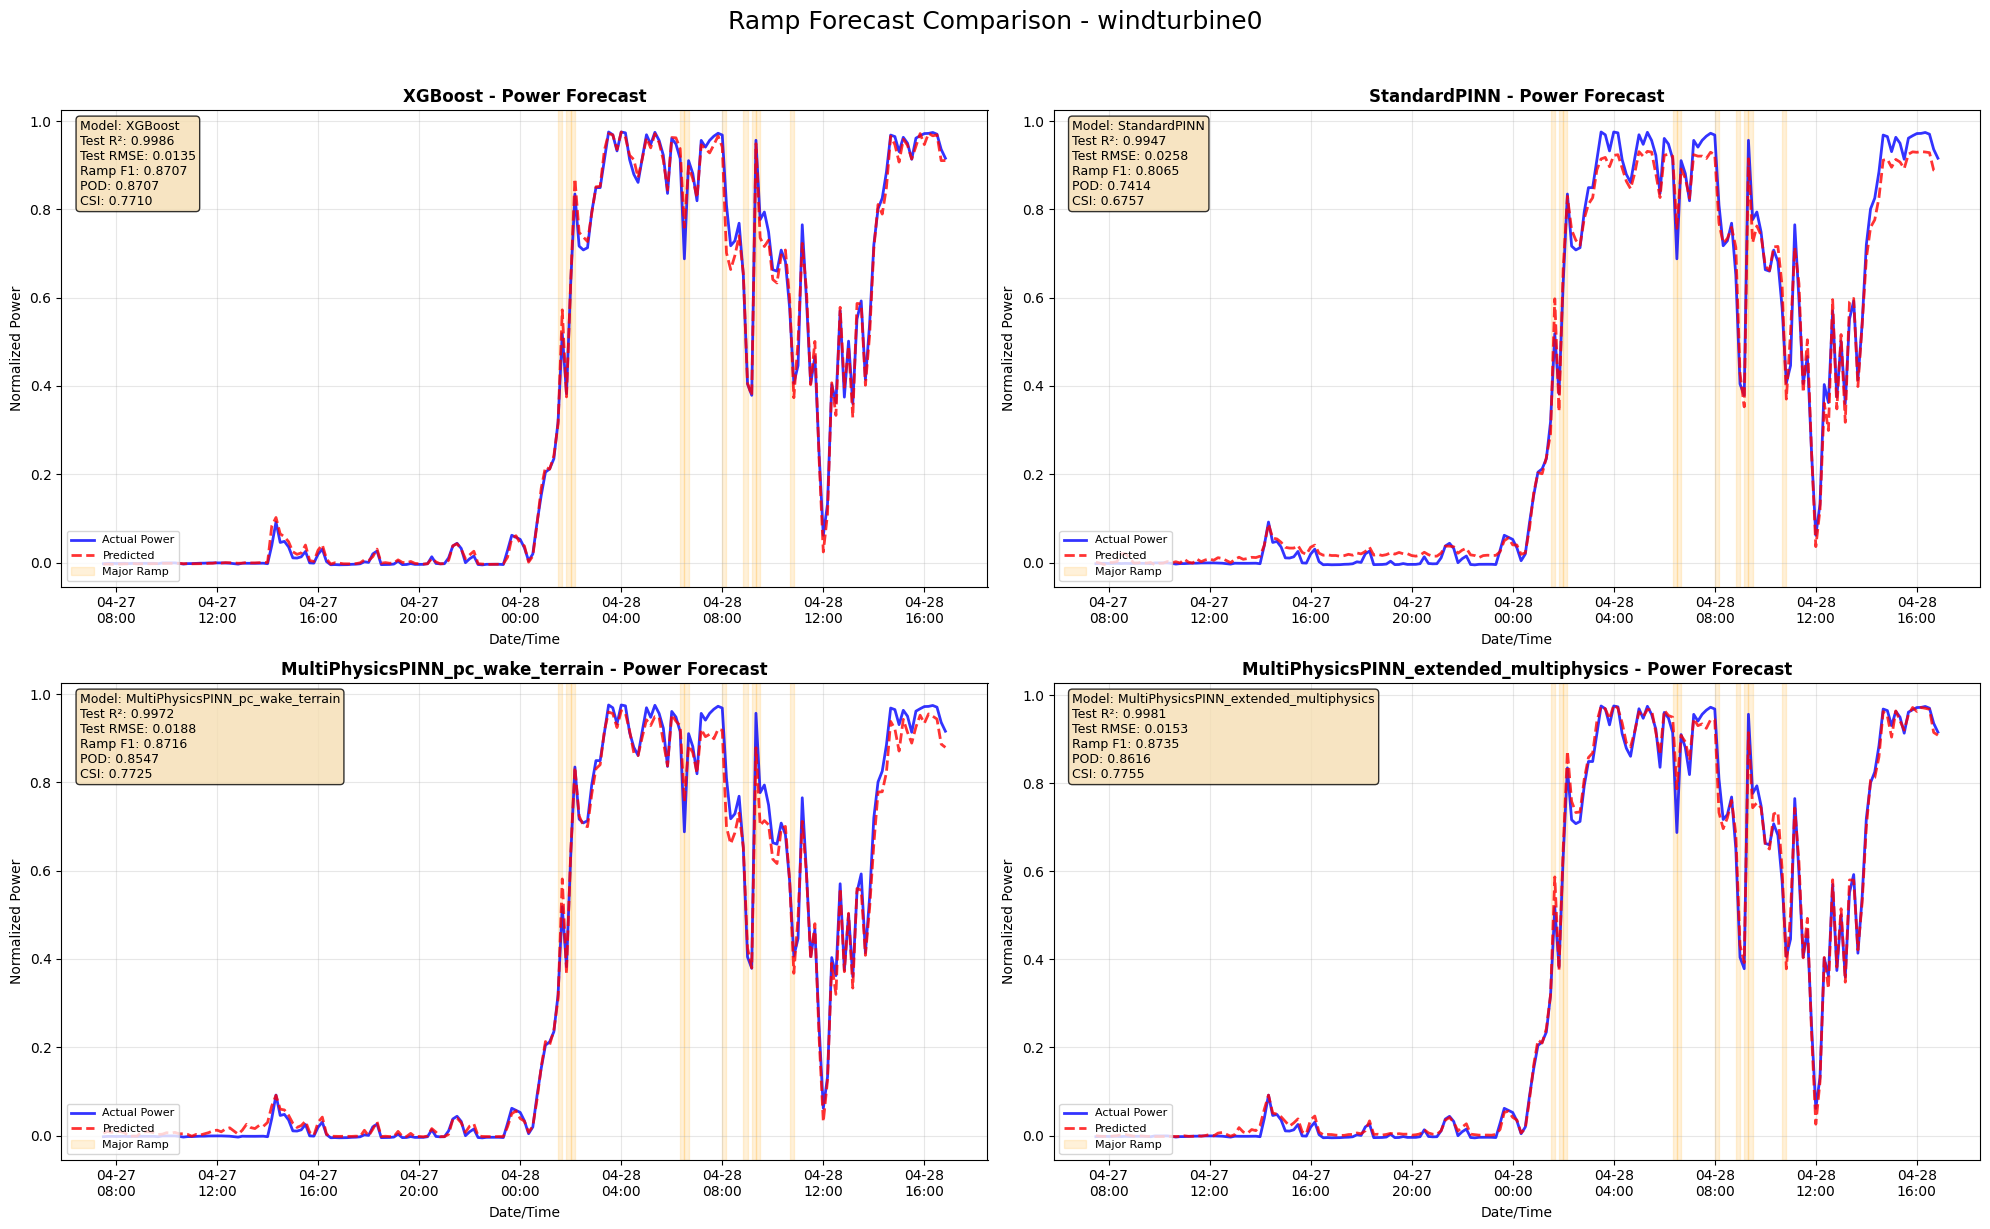

✓ Ramp forecast plots with datetime saved to: /content/drive/MyDrive/data scada/plots2/windturbine0_ramp_forecasts_datetime.png


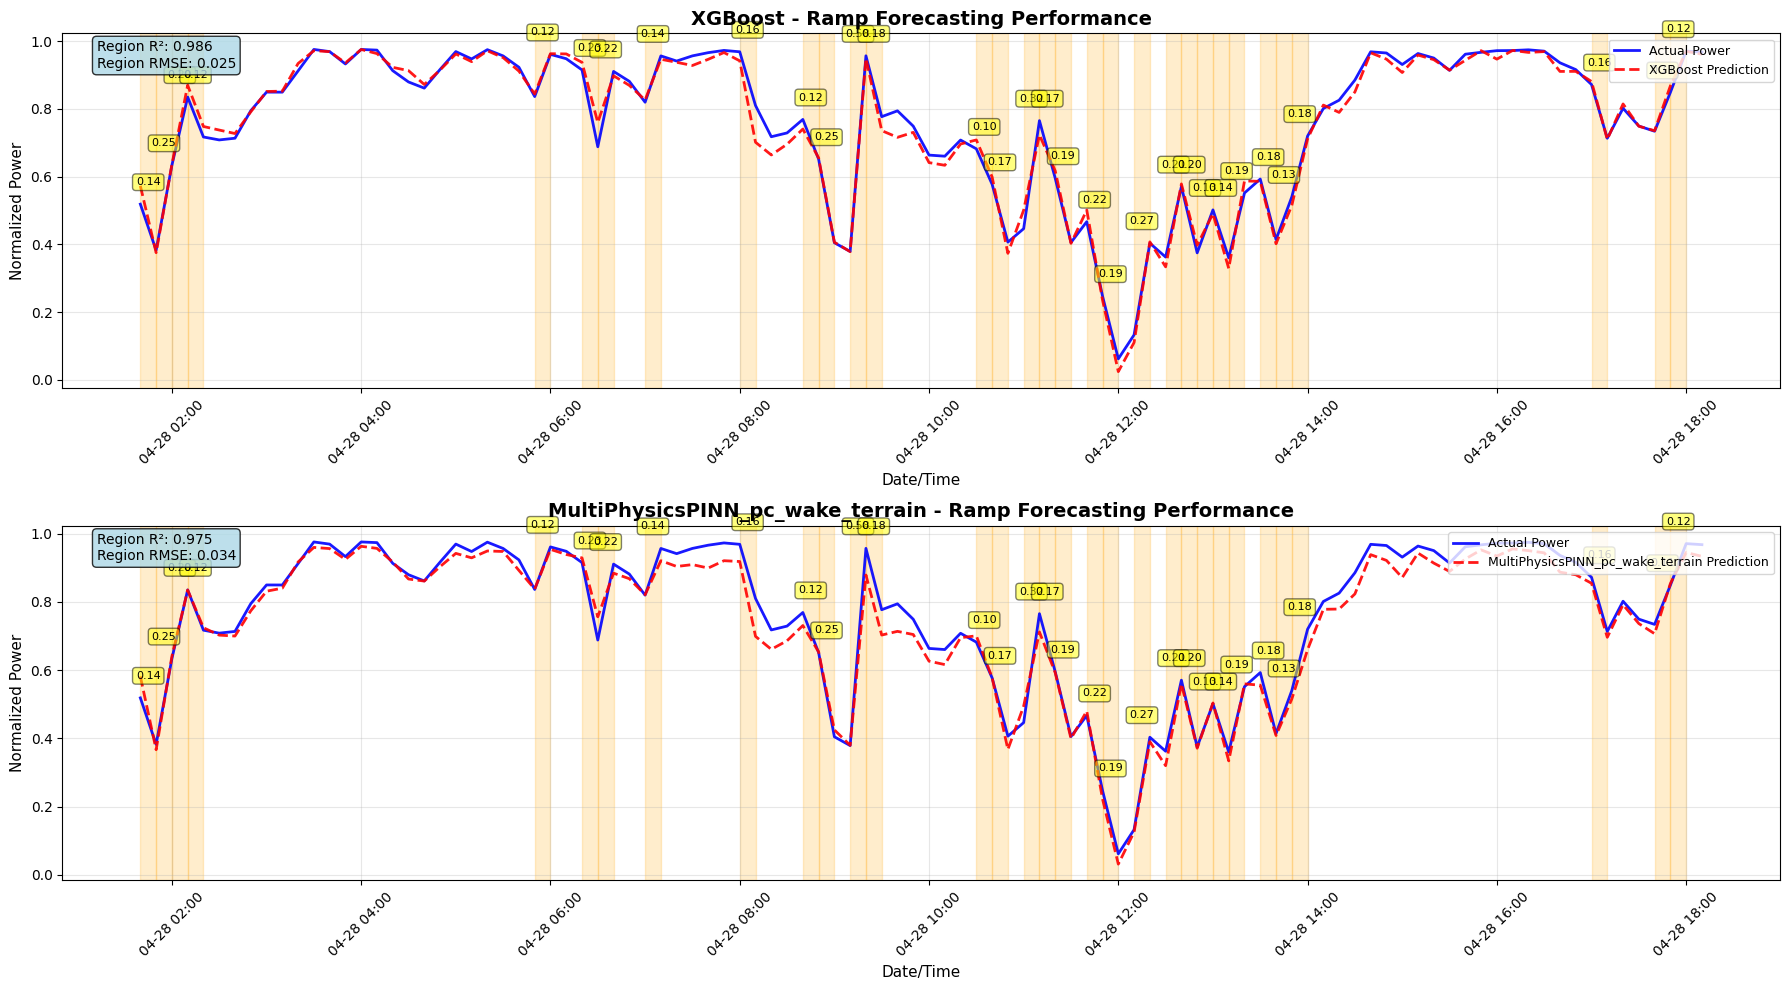

✓ Detailed comparison plot saved to: /content/drive/MyDrive/data scada/plots2/windturbine0_detailed_comparison.png

Detailed Ramp Metrics Comparison:
----------------------------------------------------------------------------------------------------
Model                               R²       RMSE     MAE      Ramp F1    POD      FAR      CSI     
----------------------------------------------------------------------------------------------------
  XGBoost                           0.9986   0.0135   0.0083   0.8707     0.8707   0.1293   0.7710  
  StandardPINN                      0.9947   0.0258   0.0206   0.8065     0.7414   0.1160   0.6757  
★ MultiPhysicsPINN_pc_wake_terrain  0.9972   0.0188   0.0129   0.8716     0.8547   0.1107   0.7725  
★ MultiPhysicsPINN_extended_multiphysics 0.9981   0.0153   0.0110   0.8735     0.8616   0.1141   0.7755  

STEP 9: CROSS-TURBINE RAMP FORECASTING COMPARISON

Running cross-turbine ramp forecasting analysis...

Cross-Turbine Ramp Forecasting Ana

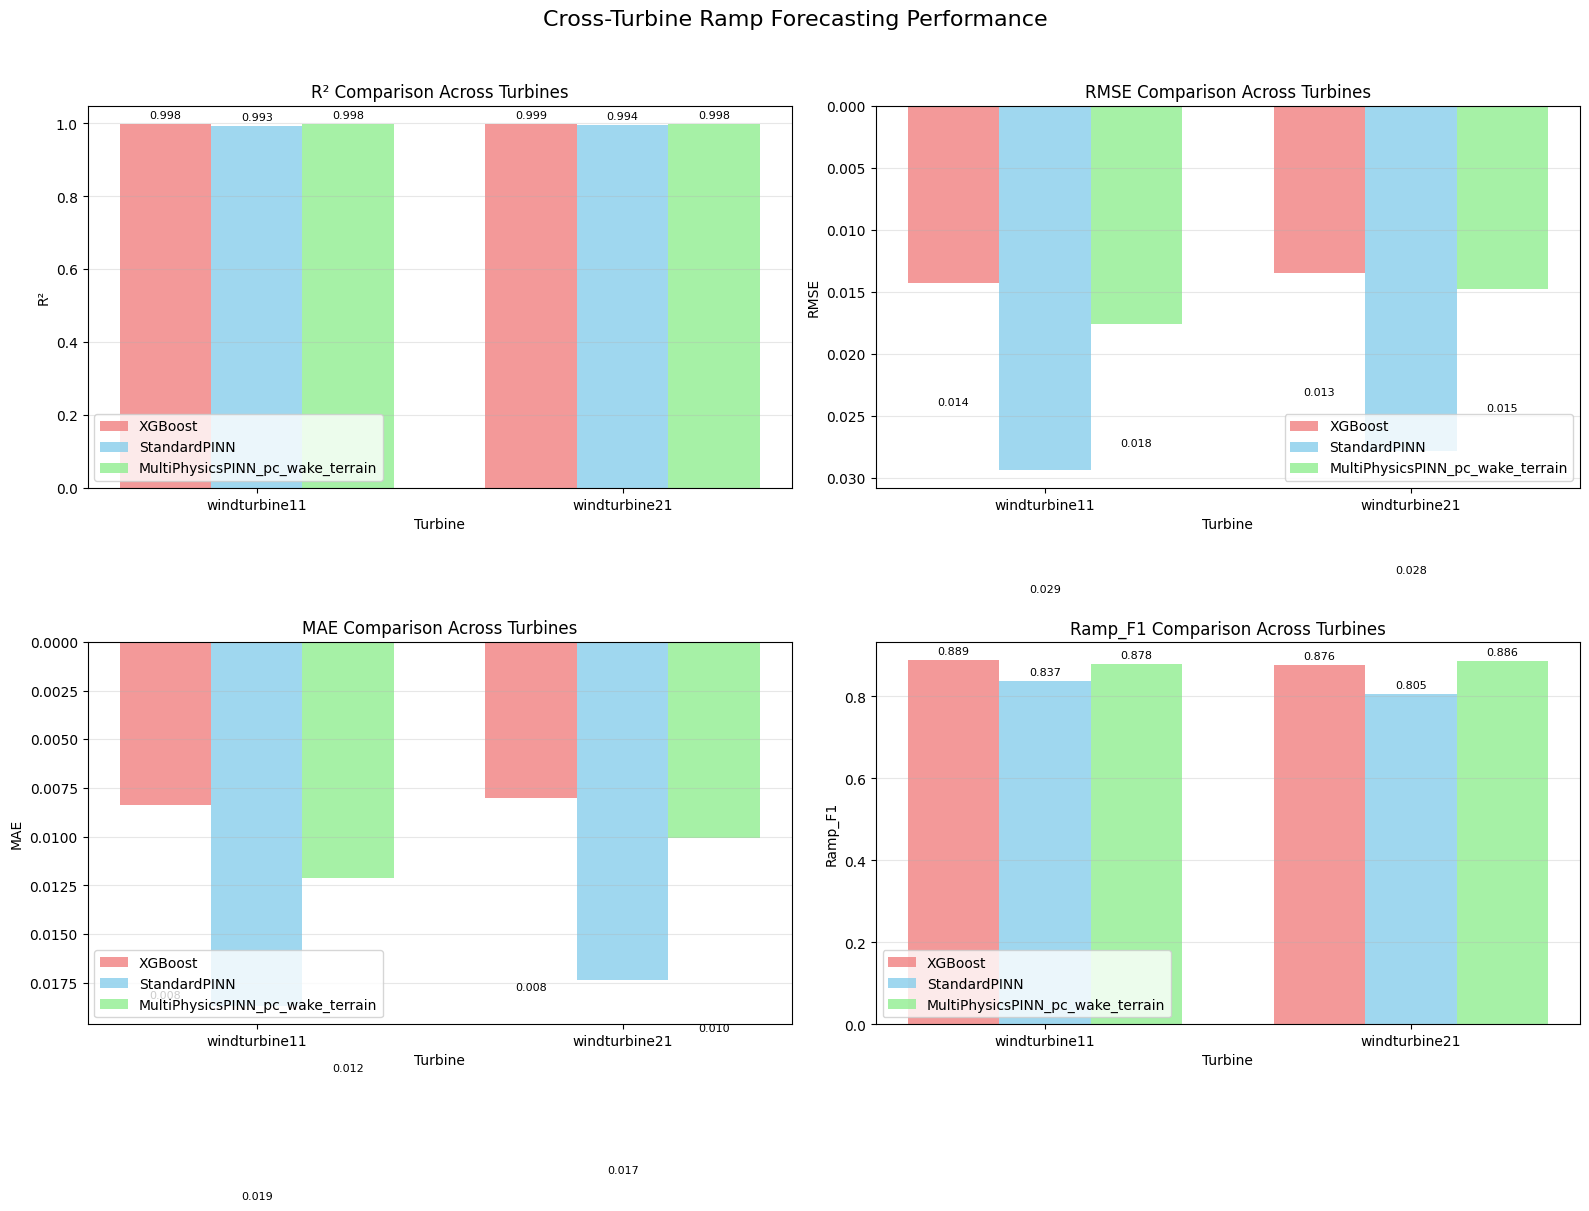

✓ Cross-turbine performance comparison plot saved to: /content/drive/MyDrive/data scada/plots2/cross_turbine_performance_comparison.png


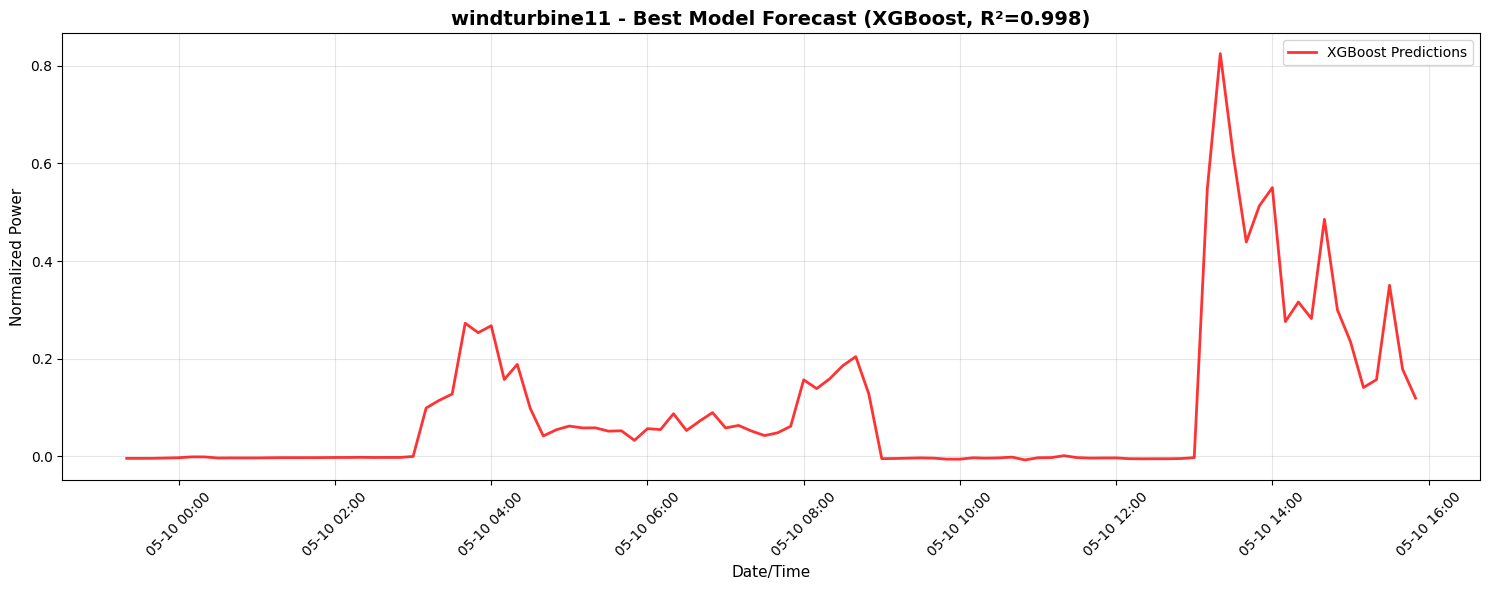

  ✓ windturbine11 forecast plot saved


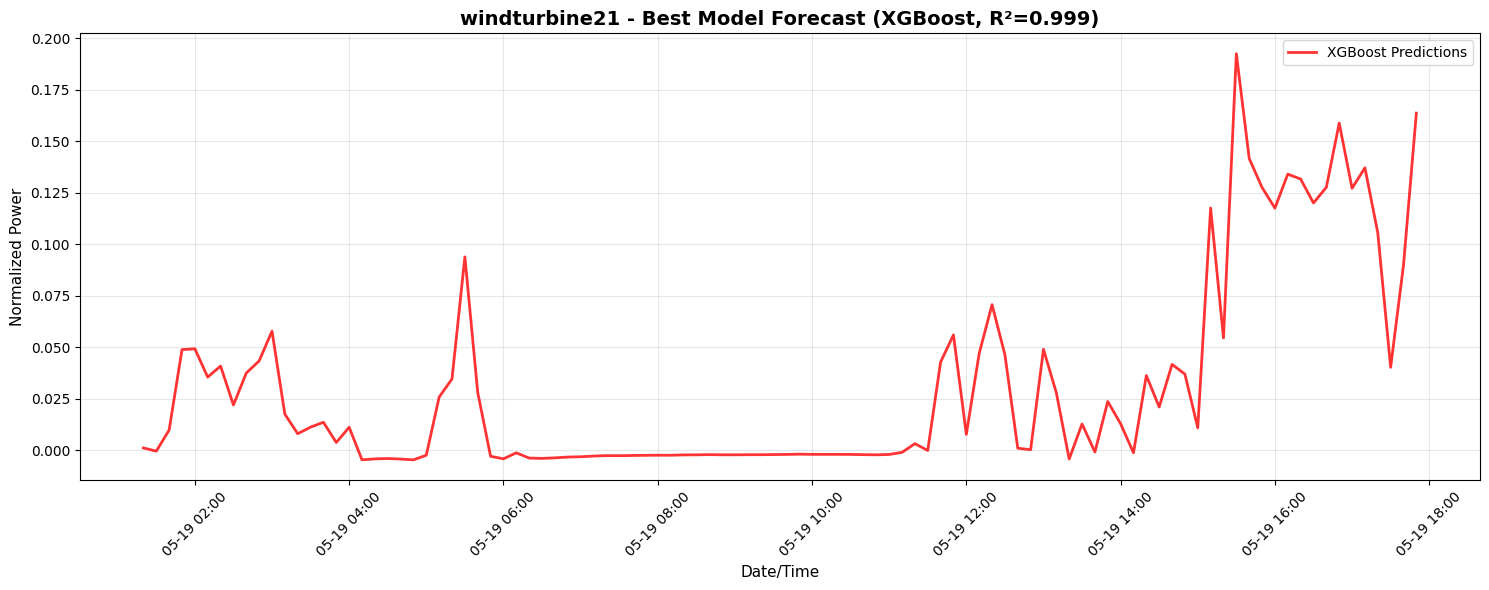

  ✓ windturbine21 forecast plot saved

CROSS-TURBINE RAMP FORECASTING COMPARISON

Cross-Turbine Performance Comparison:
------------------------------------------------------------------------------------------
      Turbine                            Model       R²     RMSE      MAE  Ramp_F1      POD      CSI
windturbine11                          XGBoost 0.998375 0.014302 0.008391 0.888675 0.887392 0.799653
windturbine11 MultiPhysicsPINN_pc_wake_terrain 0.997547 0.017574 0.012146 0.877927 0.847931 0.782416
windturbine11                     StandardPINN 0.993164 0.029334 0.018703 0.837232 0.809432 0.720034
windturbine21                          XGBoost 0.998676 0.013475 0.007999 0.876478 0.895302 0.780117
windturbine21 MultiPhysicsPINN_pc_wake_terrain 0.998408 0.014776 0.010072 0.885714 0.873826 0.794872
windturbine21                     StandardPINN 0.994356 0.027824 0.017359 0.805304 0.774497 0.674065
----------------------------------------------------------------------------------

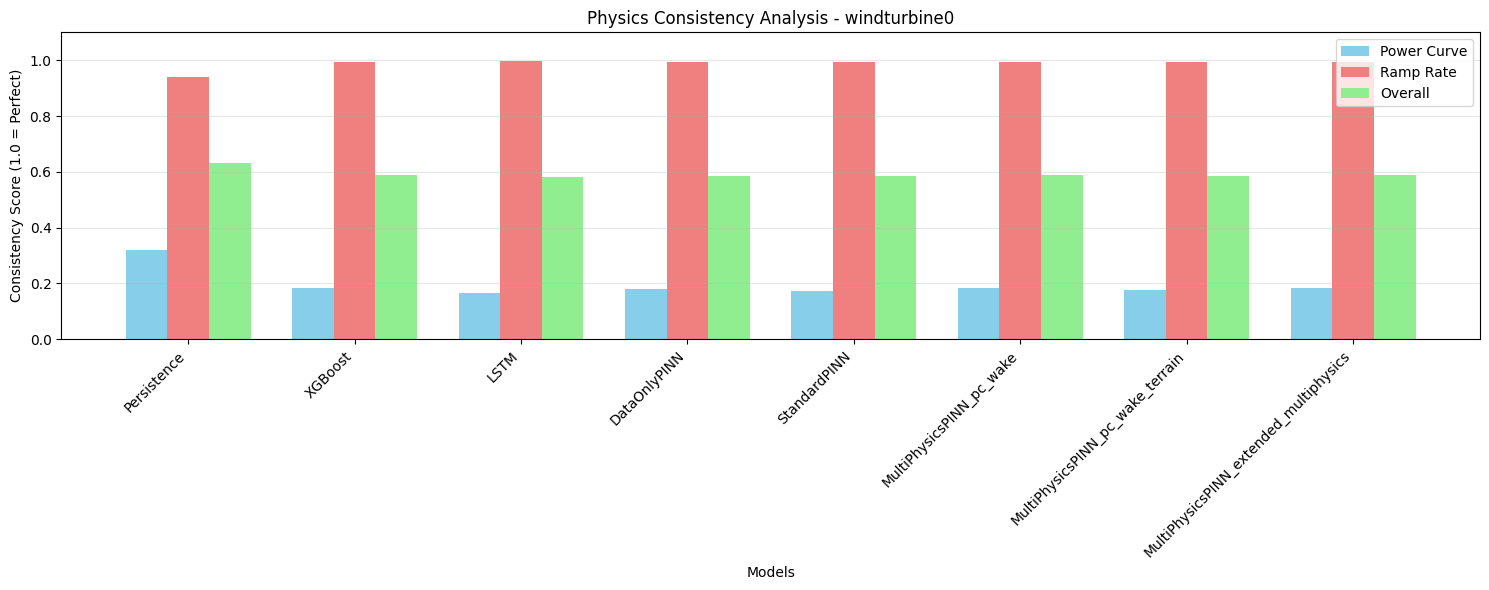


✓ Physics consistency analysis saved to: /content/drive/MyDrive/data scada/plots2/windturbine0_physics_consistency.png

FINAL SUMMARY

🎯 Research Design Implementation Complete!

Key Features Implemented:
1. ✅ Ablation study with 9 different model configurations
2. ✅ Event-based ramp verification with POD, FAR, CSI metrics
3. ✅ Physics consistency evaluation
4. ✅ Cross-turbine validation
5. ✅ Comprehensive performance comparison

📊 Key Results:
• Total models trained and tested: 8
• Top performing model: XGB (R²: 0.9986)
• Best ramp detection: XGB (Ramp F1: 0.8707)
• Cross-validation completed on 4 turbines

📁 Outputs Saved:
• Optimized hyperparameters
• Performance comparison tables
• Performance plots
• Ramp forecast visualizations
• Physics consistency analysis
• Cross-validation results

🔬 Novel Contributions Implemented:
1. Dynamic Power Curve Adaptation
2. Wake Propagation Dynamics
3. Terrain-Induced Turbulence Modeling
4. Physics-Explainable Forecasting

🎉 Analysis Complete!


In [13]:
print("\n" + "="*80)
print("STEP 10: PHYSICS CONSISTENCY ANALYSIS")
print("="*80)

def analyze_physics_consistency(all_results, turbine_data, turbine_name='windturbine0'):
    """Analyze physics consistency of predictions"""

    # Get test data
    X, y, months, seasons, feature_names = prepare_data_with_seasons(turbine_data[turbine_name])
    train_size = int(0.7 * len(X))
    val_size = int(0.15 * len(X))
    X_test = X[train_size + val_size:]

    # Define physics constraints
    def check_power_curve(predictions, wind_speeds):
        """Check if predictions follow power curve"""
        if len(predictions) == 0:
            return 0.0

        violations = 0
        cut_in, rated = 0.16, 0.6

        for pred, ws in zip(predictions, wind_speeds):
            if ws < cut_in and pred > 0.1:  # Should be near zero
                violations += 1
            elif ws > rated and pred < 0.8:  # Should be near rated
                violations += 1

        return 1.0 - (violations / len(predictions))

    def check_ramp_rates(predictions, max_rate=0.3):
        """Check for unrealistic ramp rates"""
        if len(predictions) < 2:
            return 1.0

        ramp_rates = np.abs(np.diff(predictions))
        violations = np.sum(ramp_rates > max_rate)

        return 1.0 - (violations / (len(predictions) - 1))

    # Find wind speed index
    ws_idx = None
    for i, name in enumerate(feature_names):
        if 'wind_speed' in name.lower():
            ws_idx = i
            break

    if ws_idx is None:
        ws_idx = 0

    print("\nPhysics Consistency Analysis:")
    print("-" * 80)
    print(f"{'Model':<30} {'Power Curve':<15} {'Ramp Rate':<15} {'Overall':<15}")
    print("-" * 80)

    consistency_results = {}

    for model_name, results in all_results.items():
        if 'test_predictions' in results:
            predictions = results['test_predictions']
            min_len = min(len(predictions), len(X_test))

            if min_len > 0:
                pred_sample = predictions[:min_len]
                wind_speeds = X_test[:min_len, ws_idx]

                pc_consistency = check_power_curve(pred_sample, wind_speeds)
                rr_consistency = check_ramp_rates(pred_sample)
                overall_consistency = (pc_consistency + rr_consistency) / 2

                consistency_results[model_name] = {
                    'power_curve': pc_consistency,
                    'ramp_rate': rr_consistency,
                    'overall': overall_consistency
                }

                print(f"{model_name:<30} {pc_consistency:<15.4f} {rr_consistency:<15.4f} {overall_consistency:<15.4f}")

    # Create consistency plot
    if consistency_results:
        model_names = list(consistency_results.keys())
        pc_scores = [consistency_results[m]['power_curve'] for m in model_names]
        rr_scores = [consistency_results[m]['ramp_rate'] for m in model_names]
        overall_scores = [consistency_results[m]['overall'] for m in model_names]

        x = np.arange(len(model_names))
        width = 0.25

        plt.figure(figsize=(15, 6))
        plt.bar(x - width, pc_scores, width, label='Power Curve', color='skyblue')
        plt.bar(x, rr_scores, width, label='Ramp Rate', color='lightcoral')
        plt.bar(x + width, overall_scores, width, label='Overall', color='lightgreen')

        plt.xlabel('Models')
        plt.ylabel('Consistency Score (1.0 = Perfect)')
        plt.title(f'Physics Consistency Analysis - {turbine_name}')
        plt.xticks(x, model_names, rotation=45, ha='right')
        plt.legend()
        plt.ylim(0, 1.1)
        plt.grid(True, alpha=0.3, axis='y')
        plt.tight_layout()

        output_dir = "/content/drive/MyDrive/data scada/plots2"
        plot_path = os.path.join(output_dir, f"{turbine_name}_physics_consistency.png")
        plt.savefig(plot_path, dpi=300, bbox_inches='tight')
        plt.show()

        print(f"\n✓ Physics consistency analysis saved to: {plot_path}")

    return consistency_results

# Analyze physics consistency - UPDATED: pass turbine_data parameter
print("\nAnalyzing physics consistency of predictions...")
physics_consistency = analyze_physics_consistency(all_results_wt0, turbine_data, 'windturbine0')
